In [304]:
#Import pandas, matplotlib.pyplot, and seaborn 
import pandas as pd
import numpy as np
import math
import missingno as msno
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

import calendar
from scipy.signal import argrelextrema


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm

import lightgbm
from bayes_opt import BayesianOptimization

In [305]:
data = pd.read_excel('data2017_2020.xlsx')
print(data.shape)
data.head()

(412, 5)


,RATE,month_start,DWEL_UNIT,days_to_count_in_period,usage_to_count_in_period
0,COM,2016-04-01,1,19,1.4
1,COM,2016-05-01,1,12,0.5
2,COM,2016-11-01,3,56,5.7
3,COM,2016-12-01,4,62,6.7
4,COM,2017-01-01,5,69,8.4


In [306]:
data = data.groupby(['RATE', 'month_start'])[['DWEL_UNIT','days_to_count_in_period','usage_to_count_in_period']].\
    sum().reset_index()
data.columns = ['RATE', 'month_start', 'DWEL_UNIT','days','usage']
print(data.shape)
data.head()

(309, 5)


,RATE,month_start,DWEL_UNIT,days,usage
0,COM,2016-04-01,2,39,6.1
1,COM,2016-05-01,1,12,0.5
2,COM,2016-11-01,3,56,5.7
3,COM,2016-12-01,4,62,6.7
4,COM,2017-01-01,5,69,8.4


In [307]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RATE         309 non-null    object        
 1   month_start  309 non-null    datetime64[ns]
 2   DWEL_UNIT    309 non-null    int64         
 3   days         309 non-null    int64         
 4   usage        309 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 12.2+ KB


In [308]:
data['year']= data.month_start.dt.year
data['month'] = data.month_start.dt.month
data.head()

,RATE,month_start,DWEL_UNIT,days,usage,year,month
0,COM,2016-04-01,2,39,6.1,2016,4
1,COM,2016-05-01,1,12,0.5,2016,5
2,COM,2016-11-01,3,56,5.7,2016,11
3,COM,2016-12-01,4,62,6.7,2016,12
4,COM,2017-01-01,5,69,8.4,2017,1


In [309]:
dwelling = data.groupby('RATE')['DWEL_UNIT'].sum()
dwelling_df = dwelling.to_frame().reset_index()
dwelling_df.columns= ['RATE', 'Number_of_dwellings']
dwelling_df['portion_of_dwellings'] = round(100*dwelling_df['Number_of_dwellings'] /(dwelling_df['Number_of_dwellings'].sum()),3)
dwelling_df

,RATE,Number_of_dwellings,portion_of_dwellings
0,COM,373870,3.192
1,COM&RES,100292,0.856
2,IND,13796,0.118
3,IRR,80148,0.684
4,RDUPLX,1033188,8.822
5,RMF,6288650,53.694
6,RSFD,3822134,32.634


In [310]:
other = round(100* dwelling_df.loc[dwelling_df.portion_of_dwellings <= 0.12 ,'portion_of_dwellings'].sum(),3)

other

11.8

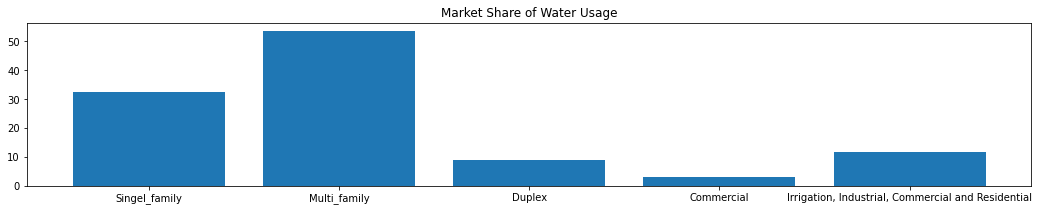

In [311]:
# Pie chart
import matplotlib.pyplot as plotter

labels = ['Singel_family', 'Multi_family', 'Duplex', 'Commercial',
          'Irrigation, Industrial, Commercial and Residential']
mkt_share =[32.6, 53.7, 8.8, 3.2, 11.8]

plt.figure(figsize=(18,3))
plt.bar(x= labels, height=mkt_share)
plt.title('Market Share of Water Usage')

plt.show()


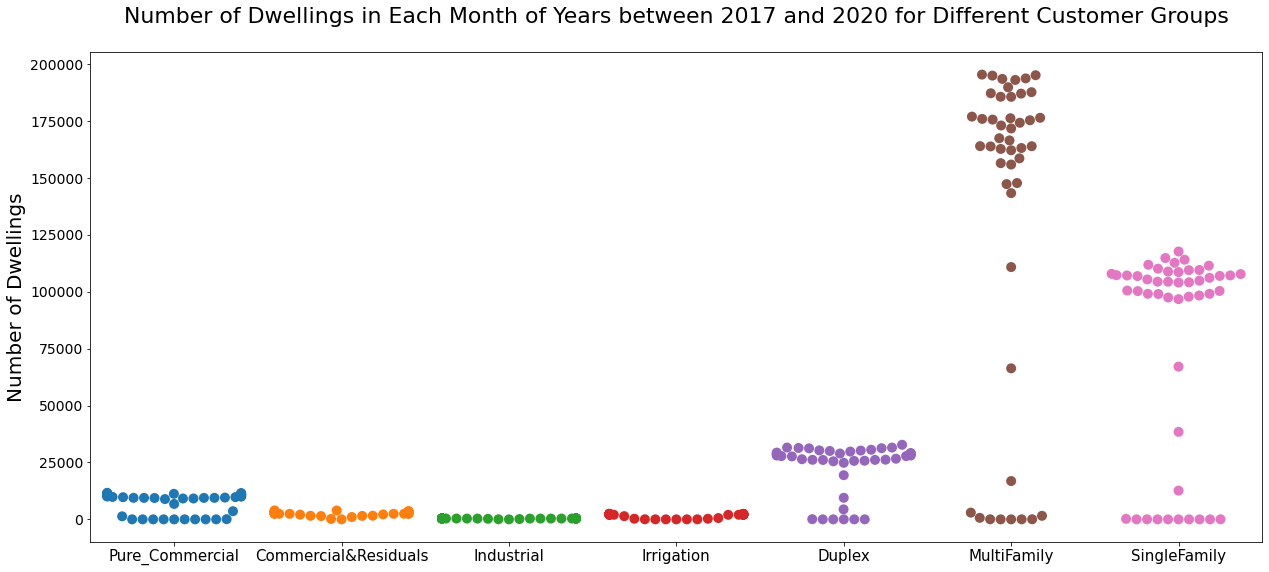

In [312]:
#Plot the range of number of dwellings in different customer groups
plt.figure(figsize=(21,9))

sns.swarmplot(x= data.RATE, y= data.DWEL_UNIT, size= 10)
plt.xticks(ticks=list(range(7)), labels=['Pure_Commercial', 'Commercial&Residuals', 'Industrial', 'Irrigation' ,\
                                         'Duplex', 'MultiFamily', 'SingleFamily'], fontsize=15)
plt.yticks(fontsize=14)
plt.xlabel('')
plt.ylabel('Number of Dwellings', fontsize=20)
plt.title('Number of Dwellings in Each Month of Years between 2017 and 2020 for Different Customer Groups\n',\
          fontsize=22)
plt.show()

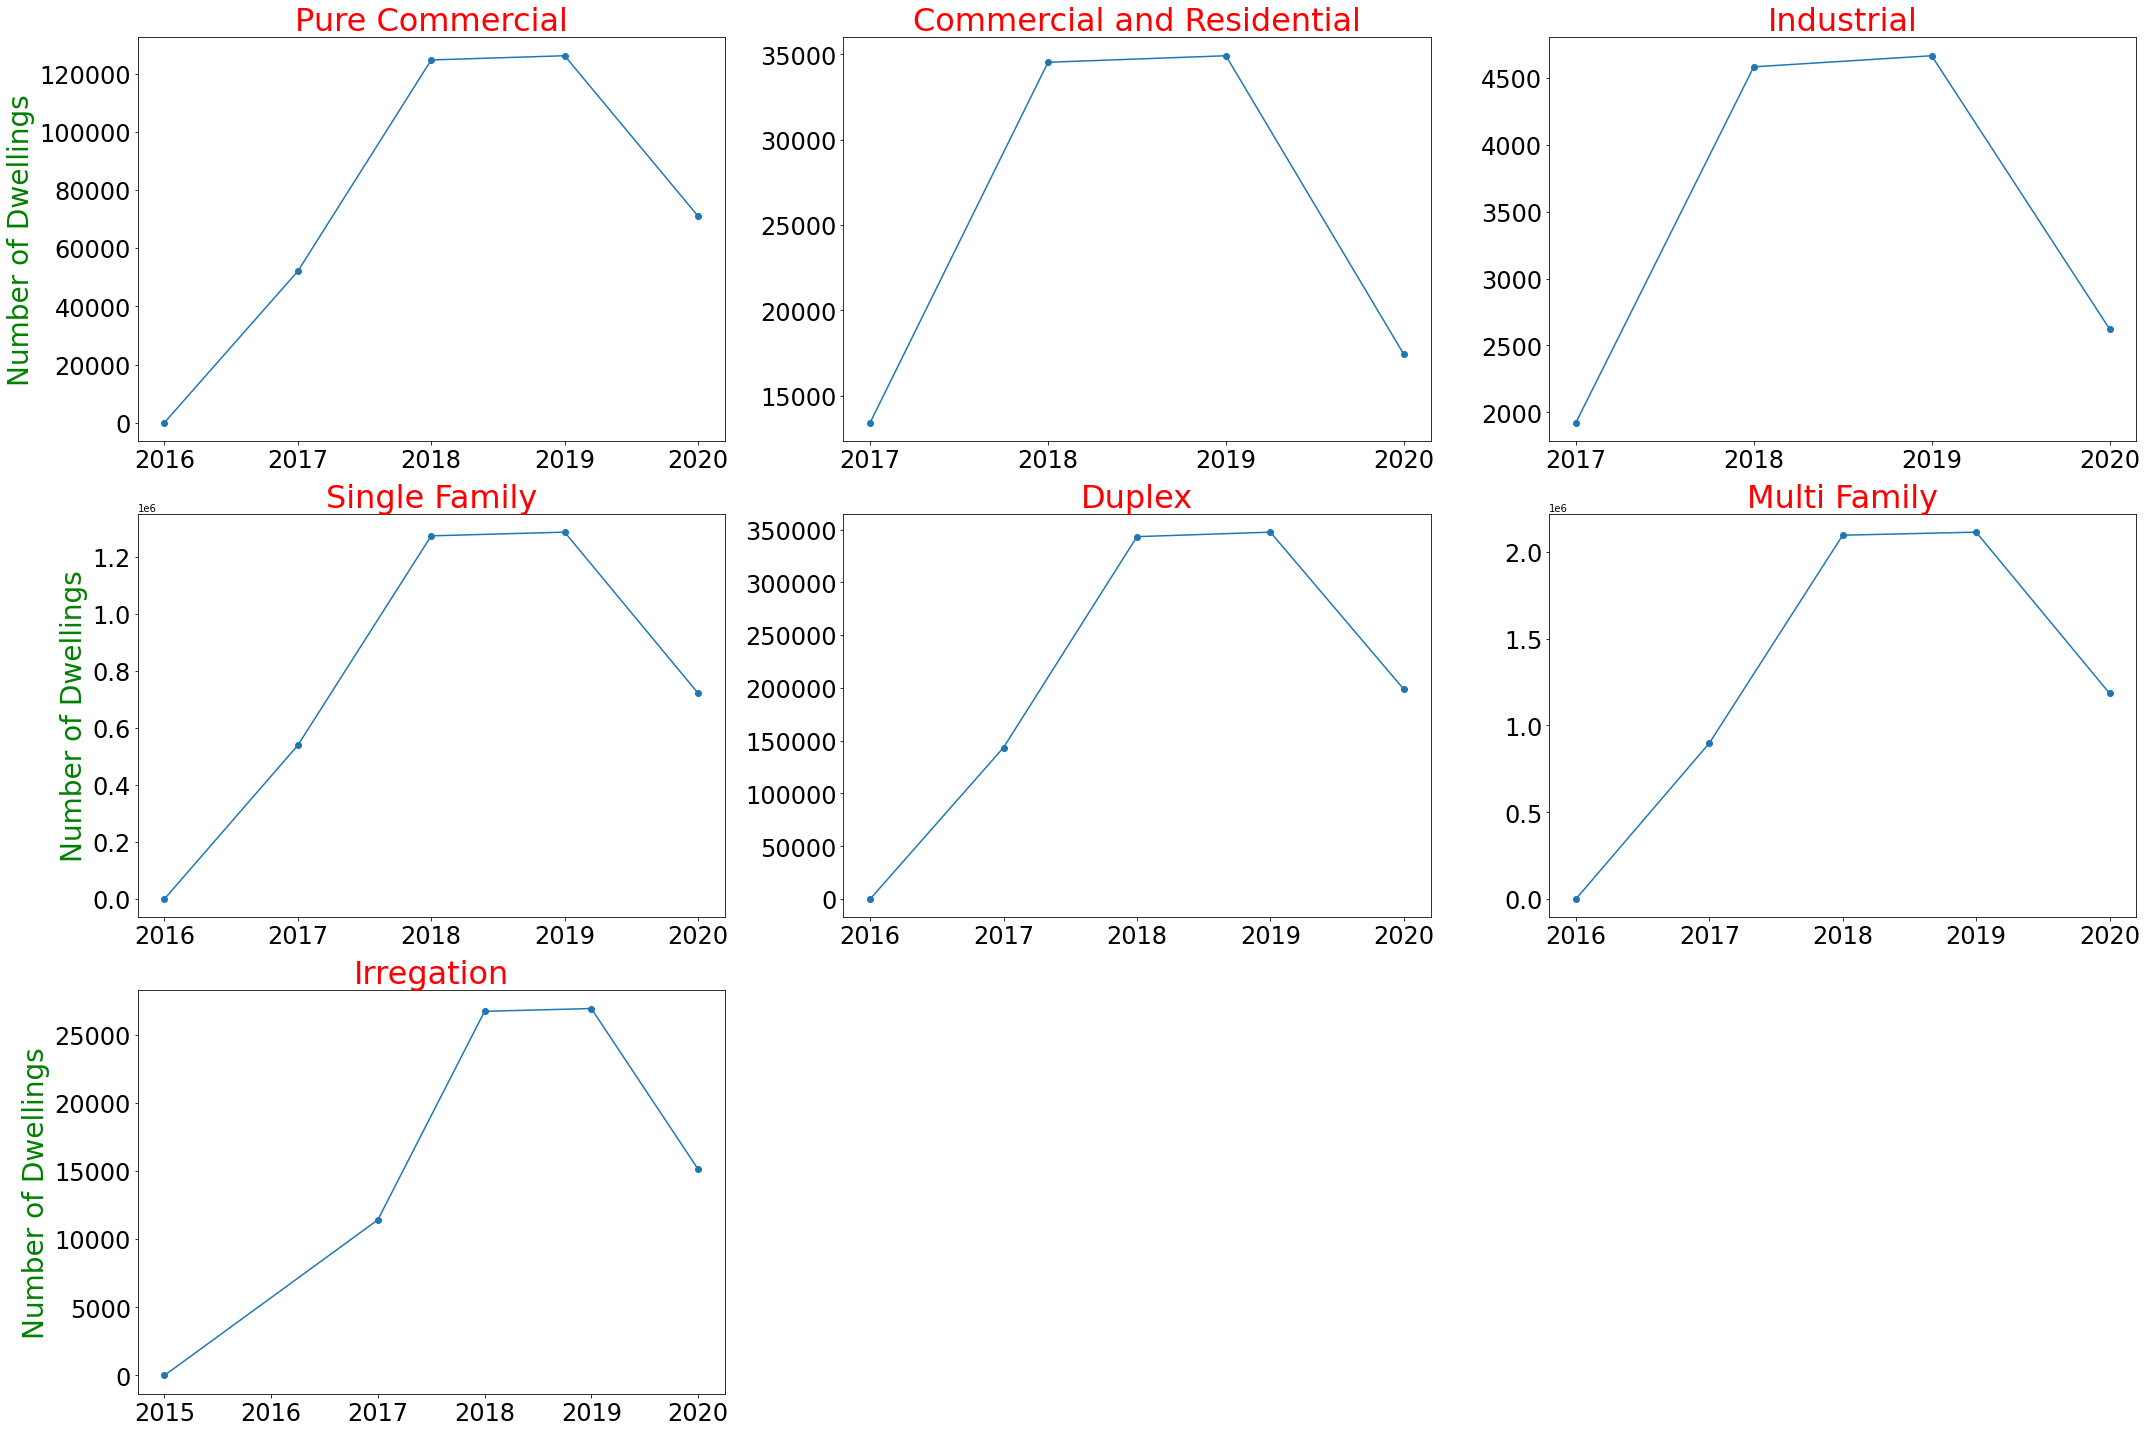

In [313]:
#Plot total number of dwellings in different customer groups
temp = data.groupby([data.RATE,data.year])['DWEL_UNIT'].sum().to_frame()
temp.reset_index(inplace=True)


plt.figure(figsize=(30,20))



ax1 = plt.subplot2grid((3,3), (0, 0))
ax2 = plt.subplot2grid((3,3), (0, 1))
ax3 = plt.subplot2grid((3,3), (0, 2))
ax4 = plt.subplot2grid((3,3), (1, 0))
ax5 = plt.subplot2grid((3,3), (1, 1))
ax6 = plt.subplot2grid((3,3), (1, 2))
ax7 = plt.subplot2grid((3,3), (2, 0))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

com = temp[temp['RATE'] == 'COM']
ax1.plot(com.year, com.DWEL_UNIT, marker='o')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_ylabel('Number of Dwellings',fontsize=28, c= 'green')
ax1.set_title('Pure Commercial',fontsize=32, c= 'red')

com_and_res = temp[temp['RATE'] == 'COM&RES']
ax2.plot(com_and_res.year, com_and_res.DWEL_UNIT, marker='o')
ax2.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax2.set_title('Commercial and Residential',fontsize=32, c= 'red')
ax2.set_xticks(com_and_res.year)

industrial = temp[temp['RATE'] == 'IND']
ax3.plot(industrial.year, industrial.DWEL_UNIT, marker='o')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax3.set_title('Industrial',fontsize=32, c= 'red')
ax3.set_xticks(industrial.year)

singlef = temp[temp['RATE'] == 'RSFD']
ax4.plot(singlef.year, singlef.DWEL_UNIT, marker='o')
ax4.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax4.set_ylabel('Number of Dwellings',fontsize=28, c= 'green')
ax4.set_title('Single Family',fontsize=32, c= 'red')

duplex = temp[temp['RATE'] == 'RDUPLX']
ax5.plot(duplex.year, duplex.DWEL_UNIT, marker='o')
ax5.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax5.set_title('Duplex',fontsize=32, c= 'red')

multif = temp[temp['RATE'] == 'RMF']
ax6.plot(multif.year, multif.DWEL_UNIT, marker='o')
ax6.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax6.set_title('Multi Family',fontsize=32, c= 'red')


irr = temp[temp['RATE'] == 'IRR']
ax7.plot(irr.year, irr.DWEL_UNIT, marker='o')
ax7.set_ylabel('Number of Dwellings',fontsize=28, c= 'green')
ax7.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax7.set_title('Irregation',fontsize=32, c= 'red')


plt.tight_layout()

plt.show()

**There are only a few recording related to water usage in 2015 and 2016, let's drop them.**

In [314]:
#Filter water usage for 2017 and onwards.
data = data[data.year >= 2017 ]
data.head()

,RATE,month_start,DWEL_UNIT,days,usage,year,month
4,COM,2017-01-01,5,69,8.4,2017,1
5,COM,2017-02-01,9,146,14.2,2017,2
6,COM,2017-03-01,8,124,18.0,2017,3
7,COM,2017-04-01,8,119,107.9,2017,4
8,COM,2017-05-01,17,271,465.0,2017,5


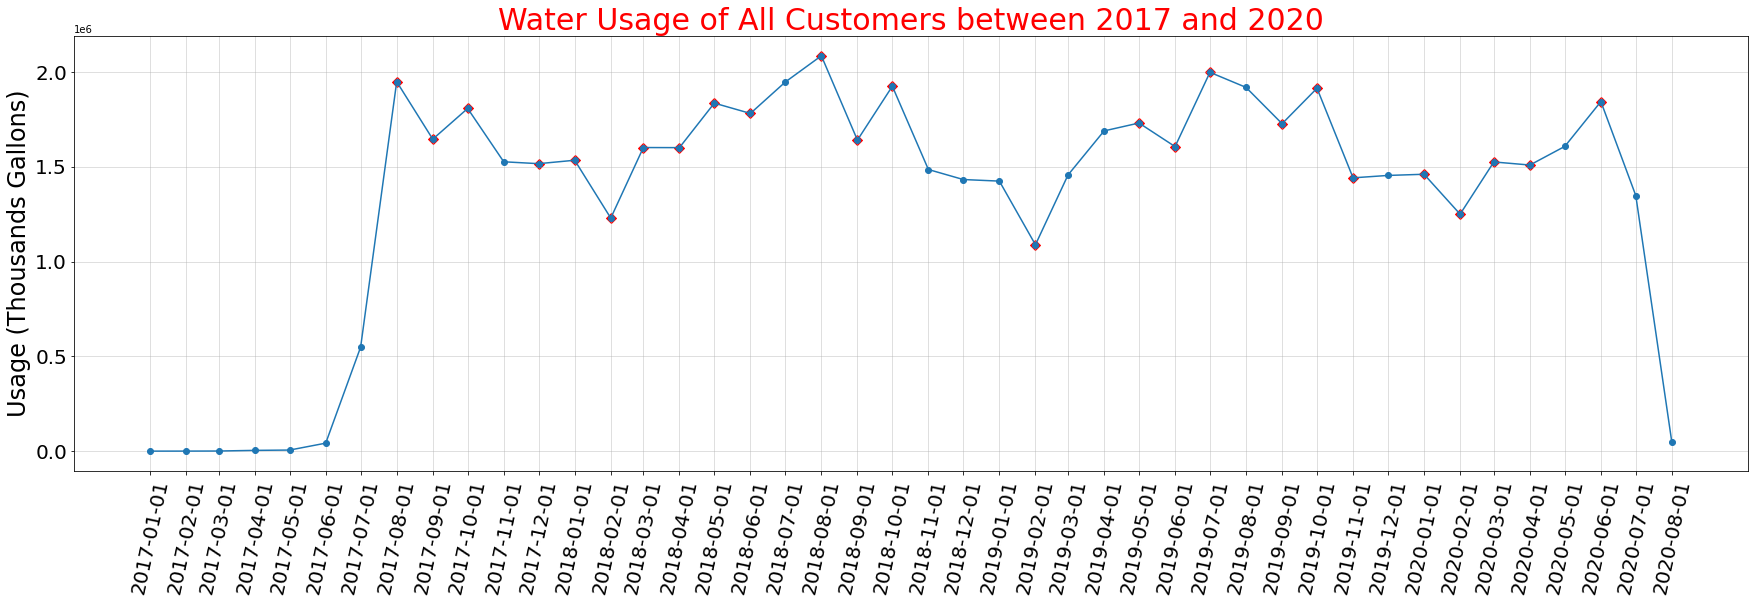

In [315]:
#Plot the water consumpotion from 2017 to 2020 for all customers
plt.figure(figsize=(30,8))
temp = data.groupby('month_start')['usage'].sum().reset_index()
plt.plot(temp.month_start, temp.usage, marker='o')


Y=np.array(temp.usage)
maxInd = argrelextrema(Y, np.greater)
minInd = argrelextrema(Y, np.less)

X=np.array(temp.month_start)
max_loc = X[maxInd]
min_loc = X[minInd]

plt.scatter(x= max_loc, y= Y[maxInd], c='red', s=50, marker='D')
plt.scatter(x= min_loc, y= Y[minInd], c='red', s=50, marker='D')

#Add corresponding grid
plt.grid(which='both')

#Set different settings for the grids
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.xticks(temp.month_start, fontsize=20, rotation=78)
plt.ylabel('Usage (Thousands Gallons)',fontsize= 24)
plt.yticks(fontsize=20)
plt.title('Water Usage of All Customers between 2017 and 2020', fontsize=30, c='red')
plt.show()


**Water usage in Feb 2018,2019,2020 were the minimum. The reason might be related to number of days in Feb (Feb 2017,2018,2019 had 28 days and Feb2020 had 29 days).**

**June, July and Augest show the relatively high usage in years of 2017,2018 and 2019, the increase in water consumption is due to summer season so there is a seasonality. But increase in usage started from April and continue until June.**

**Besides seasonality, there is a trend.**

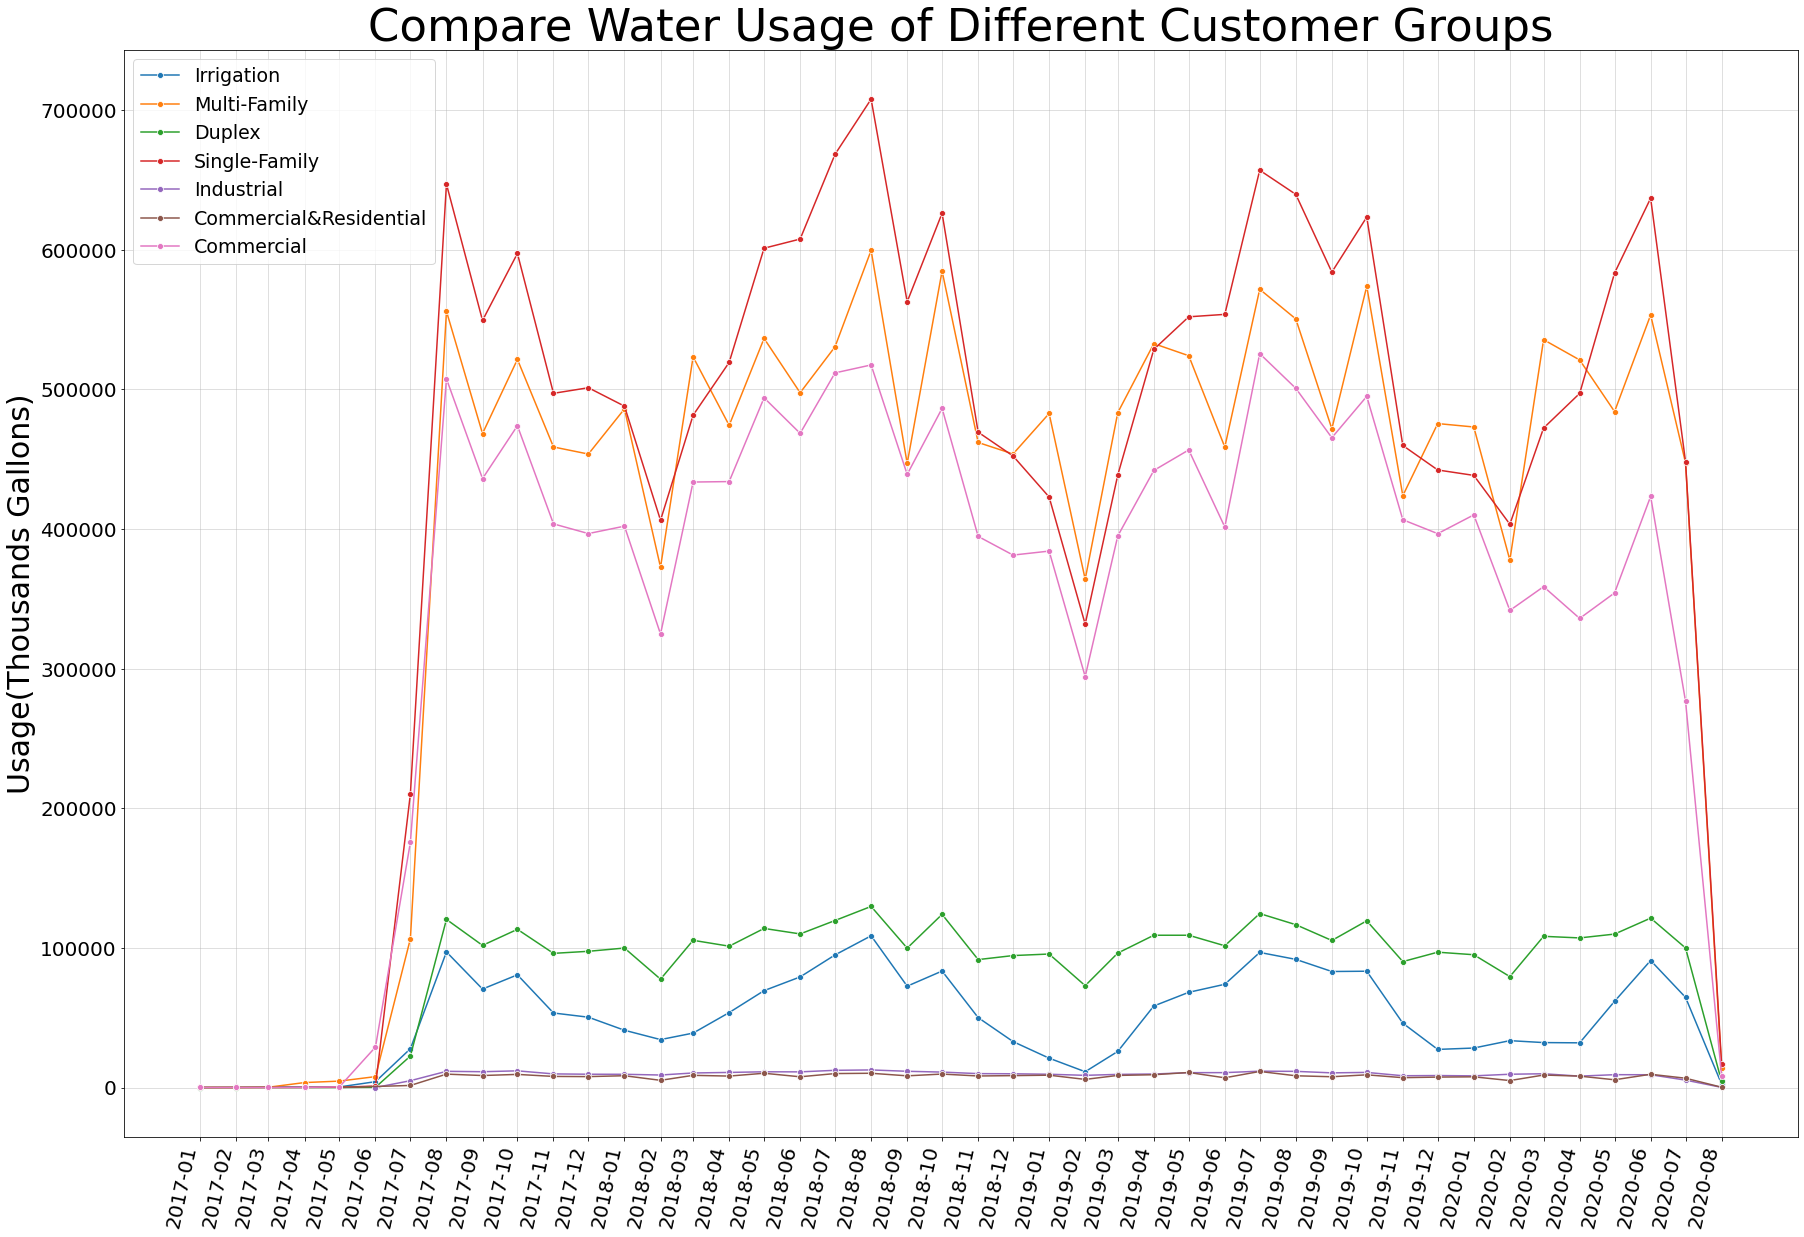

In [316]:
#plot Water Usage of Different Customer Groups
plt.figure(figsize=(30,20))
irr = data[data['RATE'] == 'IRR']
com = data[data['RATE'] == 'COM']
com_and_res = data[data['RATE'] == 'COM&RES']
industrial = data[data['RATE'] == 'IND']
singlef = data[data['RATE'] == 'RSFD']
duplex = data[data['RATE'] == 'RDUPLX']
multif = data[data['RATE'] == 'RMF']

ax = sns.lineplot(irr.month_start, irr.usage, marker="o", label='Irrigation')
sns.lineplot(multif.month_start, multif.usage, marker="o", label='Multi-Family')
sns.lineplot(duplex.month_start, duplex.usage, marker='o', label='Duplex')
sns.lineplot(singlef.month_start, singlef.usage, marker='o', label= 'Single-Family')
sns.lineplot(industrial.month_start, industrial.usage, marker='o', label='Industrial')
sns.lineplot(com_and_res.month_start, com_and_res.usage, marker='o', label='Commercial&Residential')
sns.lineplot(com.month_start, com.usage, marker='o',label='Commercial')

ax.set(xticks= irr.month_start)
ax.set_xticklabels(irr.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax.set_xlabel('')
ax.set_ylabel('Usage(Thousands Gallons)',fontsize = 30)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)

ax.legend(prop=dict(size=19))
ax.set_title('Compare Water Usage of Different Customer Groups',fontsize = 45)



#Add corresponding grid
plt.grid(which='both')

#Set different settings for the grids
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)

plt.show()

In [317]:
data = data[(data.month_start >= '2017-8-01') & (data.month_start <= '2020-07-01')]
data.shape

(252, 7)

In [318]:
#Create profiling report
report = data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)

#Save report to file
report.to_file(output_file= "usage_report.html")

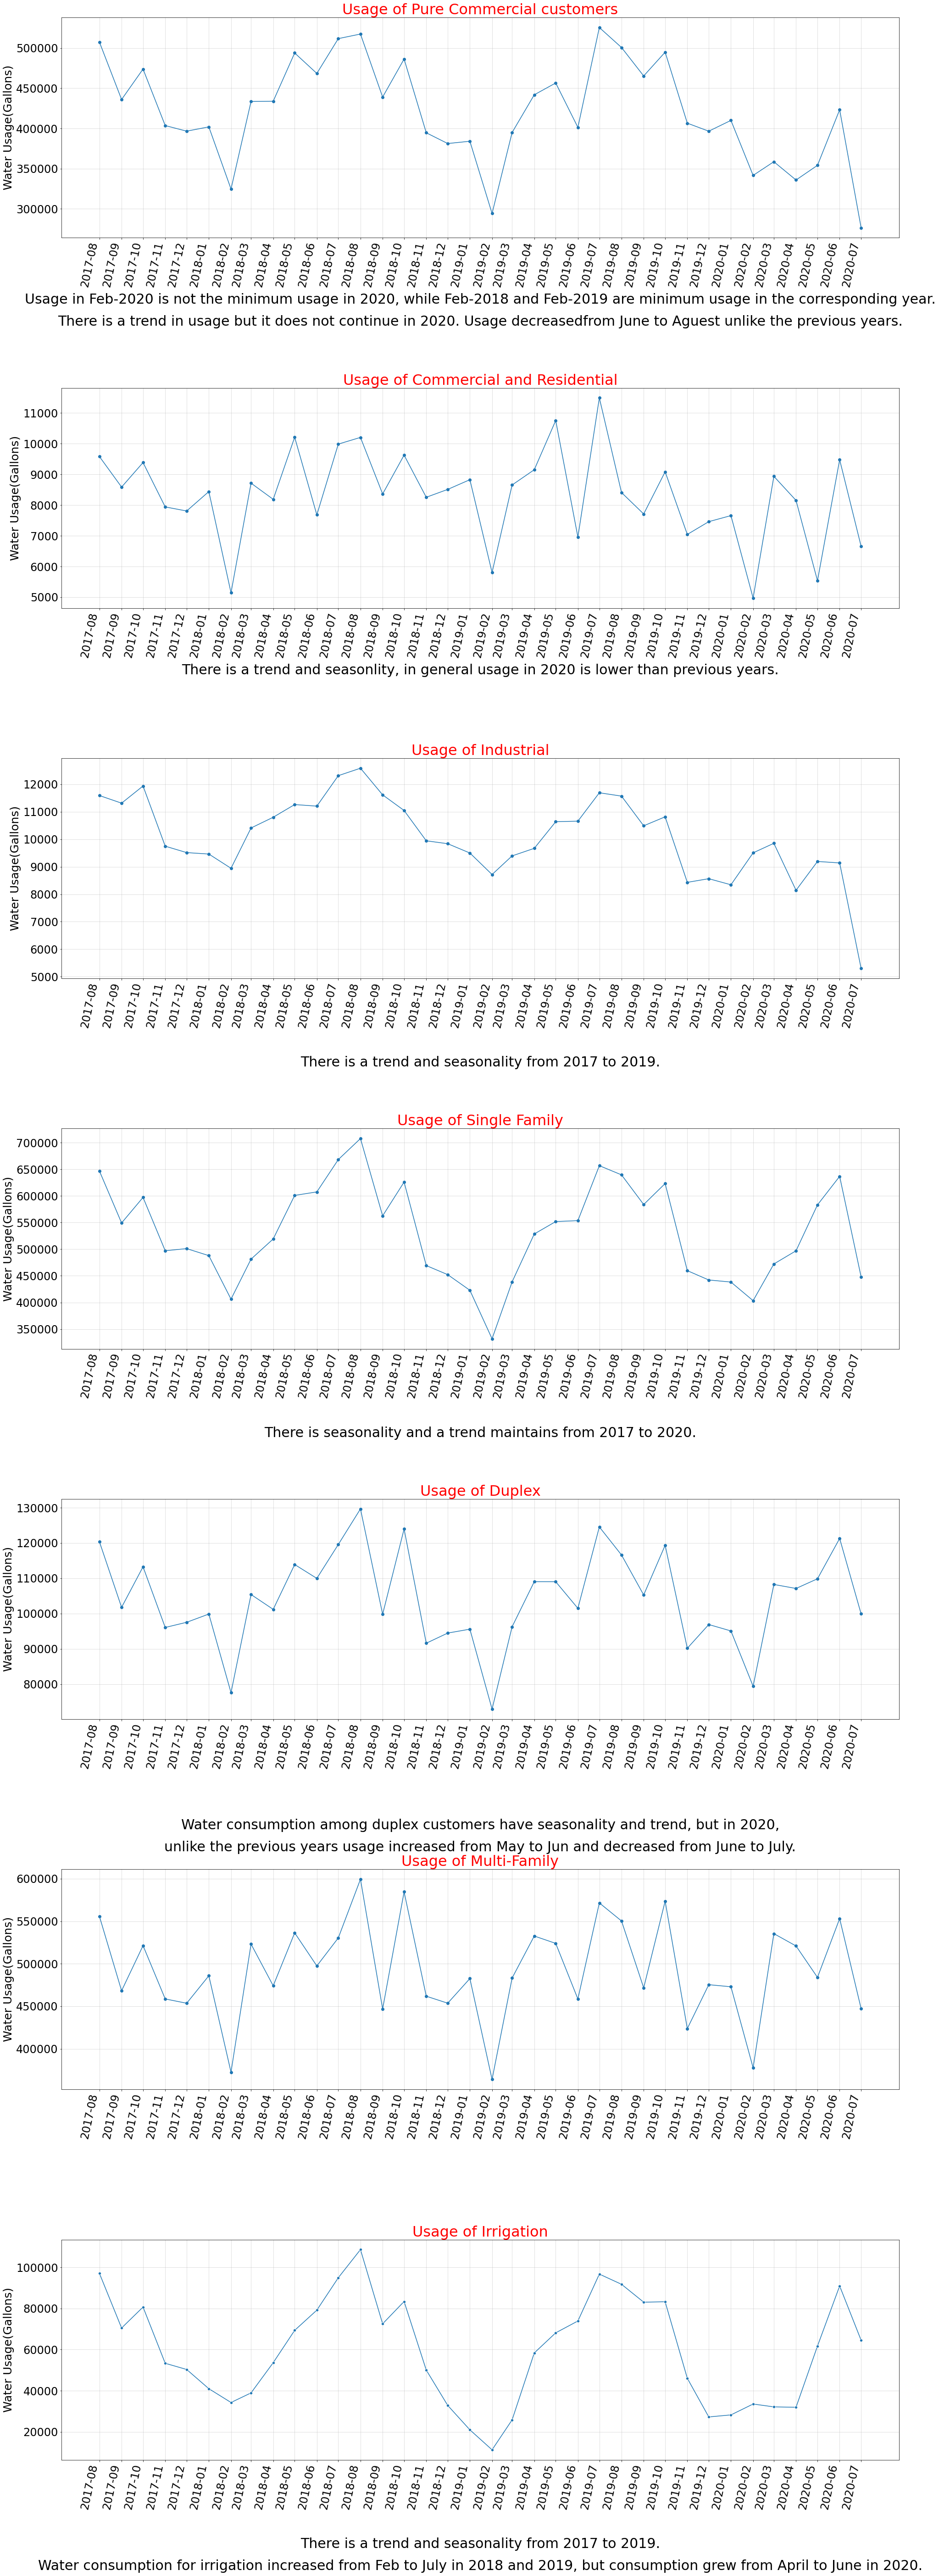

In [319]:
plt.figure(figsize=(30,78))

ax1 = plt.subplot2grid((7,1), (0, 0))
ax2 = plt.subplot2grid((7,1), (1, 0))
ax3 = plt.subplot2grid((7,1), (2, 0))
ax4 = plt.subplot2grid((7,1), (3, 0))
ax5 = plt.subplot2grid((7,1), (4, 0))
ax6 = plt.subplot2grid((7,1), (5, 0))
ax7 = plt.subplot2grid((7,1), (6, 0))


from scipy.signal import argrelextrema

plt.gcf().subplots_adjust(bottom=0.2)

#Pure commercial customers
com = data[data['RATE'] == 'COM']
ax1.plot(com.month_start, com.usage, marker='o', label='Pure Commercial')
ax1.set(xticks= com.month_start)
ax1.set_xticklabels(com.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_ylabel('Water Usage(Gallons)', fontsize=25)
ax1.set_title('Usage of Pure Commercial customers',fontsize=32, c= 'red')
#Add corresponding grid
ax1.grid(which='both')
#Set different settings for the grids
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)

ax1.text(0.5,-.3,\
    'Usage in Feb-2020 is not the minimum usage in 2020, while Feb-2018 and Feb-2019 are minimum usage in the corresponding year.',\
         size=30, ha="center", 
         transform=ax1.transAxes)
ax1.text(0.5,-.4,\
    'There is a trend in usage but it does not continue in 2020. Usage decreasedfrom June to Aguest unlike the previous years.',\
         size=30, ha="center", 
         transform=ax1.transAxes)






#Mixed commercial and residential customers
com_and_res = data[data['RATE'] == 'COM&RES']
ax2.plot(com_and_res.month_start, com_and_res.usage, marker='o')
ax2.set(xticks= com_and_res.month_start)
ax2.set_xticklabels(com_and_res.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax2.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax2.set_ylabel('Water Usage(Gallons)', fontsize=25)
ax2.set_title('Usage of Commercial and Residential',fontsize=32, c= 'red')
#Add corresponding grid
ax2.grid(which='both')
#Set different settings for the grids
ax2.grid(which='minor', alpha=0.2)
ax2.grid(which='major', alpha=0.5)


ax2.text(0.5,-.3,\
    'There is a trend and seasonlity, in general usage in 2020 is lower than previous years.',\
         size=30, ha="center", 
         transform=ax2.transAxes)





#Industrial customers
industrial = data[data['RATE'] == 'IND']
ax3.plot(industrial.month_start, industrial.usage, marker='o')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax3.set(xticks= industrial.month_start)
ax3.set_xticklabels(industrial.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax3.set_ylabel('Water Usage(Gallons)', fontsize=25)
ax3.set_title('Usage of Industrial',fontsize=32, c= 'red')
#Add corresponding grid
ax3.grid(which='both')
#Set different settings for the grids
ax3.grid(which='minor', alpha=0.2)
ax3.grid(which='major', alpha=0.5)
ax3.text(0.5,-.4,\
    'There is a trend and seasonality from 2017 to 2019.',\
         size=30, ha="center", transform=ax3.transAxes)

#Single family
singlef = data[data['RATE'] == 'RSFD']
ax4.plot(singlef.month_start, singlef.usage, marker='o')
ax4.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax4.set(xticks= singlef.month_start)
ax4.set_xticklabels(singlef.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax4.set_ylabel('Water Usage(Gallons)', fontsize=25)
ax4.set_title('Usage of Single Family',fontsize=32, c= 'red')
#Add corresponding grid
ax4.grid(which='both')
#Set different settings for the grids
ax4.grid(which='minor', alpha=0.2)
ax4.grid(which='major', alpha=0.5)


ax4.text(0.5,-.4,'There is seasonality and a trend maintains from 2017 to 2020.',\
         size=30, ha="center", 
         transform=ax4.transAxes)






#Duplex
duplex = data[data['RATE'] == 'RDUPLX']
ax5.plot(duplex.month_start, duplex.usage, marker='o')
ax5.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax5.set(xticks= duplex.month_start)
ax5.set_xticklabels(duplex.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax5.set_ylabel('Water Usage(Gallons)', fontsize=25)
ax5.set_title('Usage of Duplex',fontsize=32, c= 'red')
#Add corresponding grid
ax5.grid(which='both')
#Set different settings for the grids
ax5.grid(which='minor', alpha=0.2)
ax5.grid(which='major', alpha=0.5)

ax5.text(0.5,-.5,'Water consumption among duplex customers have seasonality and trend, but in 2020,',\
         size=30, ha="center", 
         transform=ax5.transAxes)
ax5.text(0.5,-.6,'unlike the previous years usage increased from May to Jun and decreased from June to July.',\
         size=30, ha="center", 
         transform=ax5.transAxes)





#Multi family
multif = data[data['RATE'] == 'RMF']
ax6.plot(multif.month_start, multif.usage, marker="o")
ax6.set(xticks= multif.month_start)
ax6.set_xticklabels(multif.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax6.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax6.set_xticklabels(multif.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax6.set_ylabel('Water Usage(Gallons)', fontsize=25)
ax6.set_title('Usage of Multi-Family',fontsize=32, c= 'red')
#Add corresponding grid
ax6.grid(which='both')
#Set different settings for the grids
ax6.grid(which='minor', alpha=0.2)
ax6.grid(which='major', alpha=0.5)




#Irrigation
irr = data[data['RATE'] == 'IRR']
ax7 = sns.lineplot(irr.month_start, irr.usage, marker="o")
ax7.set(xticks= irr.month_start)
ax7.set_xlabel('')
ax7.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax7.set_xticklabels(irr.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax7.set_ylabel('Water Usage(Gallons)', fontsize=25)
ax7.set_title('Usage of Irrigation',fontsize=32, c= 'red')
#Add corresponding grid
ax7.grid(which='both')
#Set different settings for the grids
ax7.grid(which='minor', alpha=0.2)
ax7.grid(which='major', alpha=0.5)
ax7.text(0.5,-.4,\
    'There is a trend and seasonality from 2017 to 2019.',\
         size=30, ha="center", transform=ax7.transAxes)
ax7.text(0.5,-.5,\
    'Water consumption for irrigation increased from Feb to July in 2018 and 2019, but consumption grew from April to June in 2020.',\
         size=30, ha="center", transform=ax7.transAxes)



plt.tight_layout() 
plt.show()

-----

# 2) Forecasting Models

## 2.1. Lasso and ElasticNet Models

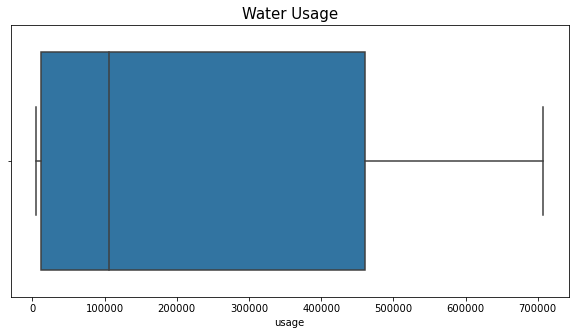

In [320]:
plt.figure(figsize=(10,5))
sns.boxplot(data.usage)
plt.title('Water Usage', fontsize=15 )
plt.show()

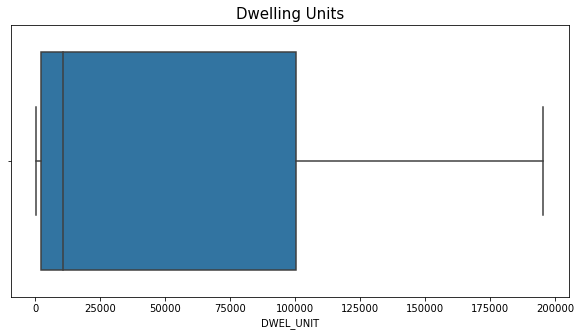

In [322]:
plt.figure(figsize=(10,5))
sns.boxplot(data.DWEL_UNIT)
plt.title('Dwelling Units', fontsize=15 )
plt.show()

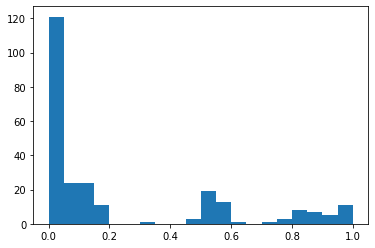

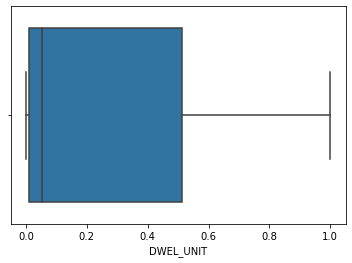

In [323]:
min_max_DWEL_UNIT = (data['DWEL_UNIT'] - data['DWEL_UNIT'].min()) / (data['DWEL_UNIT'].max() - data['DWEL_UNIT'].min())
plt.hist(min_max_DWEL_UNIT ,bins=20)
plt.show()
sns.boxplot(min_max_DWEL_UNIT)
plt.show()

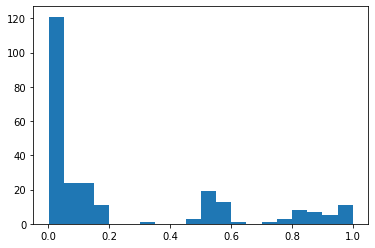

In [324]:
data['pct_dwel'] = data['DWEL_UNIT']/ max(data['DWEL_UNIT'])
plt.hist(data['pct_dwel'], bins=20)
plt.show()

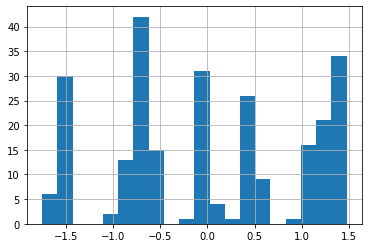

In [325]:
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
log.fit(data[['DWEL_UNIT']])
data['log_DWEL'] = log.transform(data[['DWEL_UNIT']])
data['log_DWEL'].hist(bins=20)
plt.show()

### 1) Distribution of Dwelling Unit and Usage are both very skewed and has a long right tail. The large values
### are not outliers and mostly happened due to large number of dwelling unit and usage of multi-family group.

### 2) I tried log transform and normalizing but none of them didn't change the shape of the distributions and 
### also didn't improve the result of models.

In [326]:
df = data[['RATE', 'year', 'month', 'DWEL_UNIT', 'usage']]
print(df.shape)
df.head()

(252, 5)


,RATE,year,month,DWEL_UNIT,usage
11,COM,2017,8,9470,507459.0
12,COM,2017,9,9385,436012.8
13,COM,2017,10,10456,473872.9
14,COM,2017,11,9457,403594.5
15,COM,2017,12,9571,396648.1


### Encoding RATE

In [327]:
encoded_cols = pd.get_dummies(data['RATE'], drop_first= False, prefix= 'R')
df = df.join(encoded_cols).drop('RATE',axis=1)

### Encoding year and month

In [328]:
encoded_cols = pd.get_dummies(df['year'], drop_first= False, prefix= 'Y')
df = df.join(encoded_cols).drop('year', axis=1)

encoded_cols = pd.get_dummies(df['month'], drop_first= True, prefix= 'M')
df = df.join(encoded_cols).drop('month', axis=1)

In [329]:
#set train and test size (70/30)
n = df.shape[0]
n1 =  int(0.70 * n)


y_train = df.loc[:n1,'usage']
y_test = df.loc[n1:,'usage']

X = df.drop('usage', axis=1)
X_train = X.loc[:n1,:]
X_test = X.loc[n1:,:]

print(X_train.shape , y_train.shape)

(144, 23) (144,)


### Lasso Regression Model
Lasso for feature selection 

Best Lasso Model:
Tuned Lasso- alph: 1.0
Tuned Lasso R squared: -61.21935040027963
Tuned Lasso MSE 8031511161385.498


C:\Users\bahra\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6904202771.408279, tolerance: 444622431.89715433
  model = cd_fast.enet_coordinate_descent(


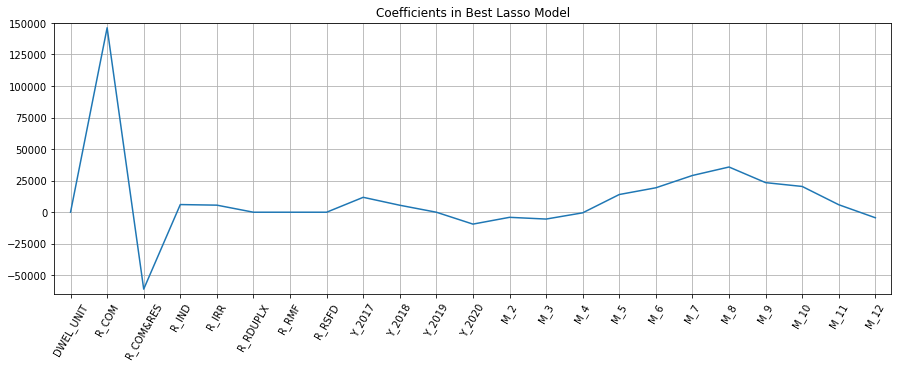

In [330]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error


# Specify a uniform random distribution as the hyperparameter search space
param_grid = {'alpha':np.logspace(-4, 0, 50)}

# Create the RandomizedSearchCV object
model = Lasso()
rand_search = RandomizedSearchCV(estimator= model, param_distributions= param_grid, n_iter= 50, n_jobs=-1)

# Fit to the training set
rand_search.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = rand_search.best_estimator_.predict(X_test)
r2 = rand_search.best_estimator_.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)


print('Best Lasso Model:')
print('Tuned Lasso- alph:', rand_search.best_estimator_.alpha)
print('Tuned Lasso R squared:', rand_search.best_score_)
print('Tuned Lasso MSE', mse)
lasso_coef = rand_search.best_estimator_.coef_


# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(X.columns)), lasso_coef)
plt.title('Coefficients in Best Lasso Model')
plt.xticks(range(len(X.columns)), X.columns, rotation=60)
plt.margins(0.02)
plt.grid(which= 'both')
plt.show()


C:\Users\bahra\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 50 is smaller than n_iter=200. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best ElasticNet Model:
Tuned ElasticNet- alph: 0.15
Tuned ElasticNet R squared: -529.9
Tuned ElasticNet MSE 21675774270468.0


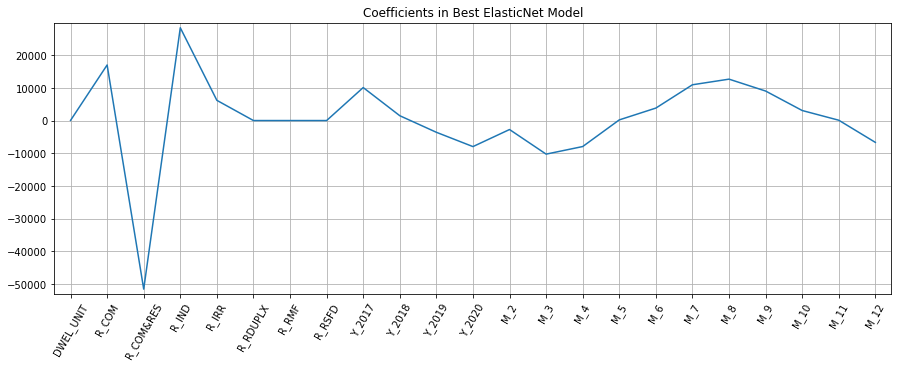

In [331]:
# Import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform 


# Specify the hyperparameter search space
param_grid = {'alpha':np.logspace(-4, 0, 50)}

# Create the RandomizedSearchCV object
model = ElasticNet()
rand_search = RandomizedSearchCV(estimator= model, param_distributions= param_grid, n_iter=200, n_jobs=-1)

# Fit to the training set
rand_search.fit(X_train,y_train)


# Predict on the test set and compute metrics
y_pred = rand_search.best_estimator_.predict(X_test)
r2 = round(rand_search.best_estimator_.score(X_test, y_test),1)
mse = round(mean_squared_error(y_test, y_pred))


print('Best ElasticNet Model:')
print('Tuned ElasticNet- alph:', round(rand_search.best_estimator_.alpha,2))
print('Tuned ElasticNet R squared:', r2)
print('Tuned ElasticNet MSE', mse)
Elastic_coef = rand_search.best_estimator_.coef_


# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(X.columns)), Elastic_coef)
plt.title('Coefficients in Best ElasticNet Model')
plt.xticks(range(len(X.columns)), X.columns, rotation=60)
plt.margins(0.02)
plt.grid(which= 'both')
plt.show()


## 2.2. RandomForset- Feature Importance

Tuned Number of Estimators: {'n_estimators': 36}

Feature Importance:
      Features  Importance
0       R_COM    0.711917
1   DWEL_UNIT    0.255263
2       R_IRR    0.014612
3      Y_2020    0.005289
4         M_8    0.003682
5         M_2    0.001763
6         M_7    0.001417
7         M_9    0.001209
8         M_3    0.000764
9         M_6    0.000705
10        M_4    0.000674
11     Y_2019    0.000591
12       M_10    0.000564
13        M_5    0.000500
14     Y_2018    0.000370
15     Y_2017    0.000288
16       M_12    0.000284
17       M_11    0.000098
18  R_COM&RES    0.000007
19      R_IND    0.000003
20     R_RSFD    0.000000
21      R_RMF    0.000000
22   R_RDUPLX    0.000000


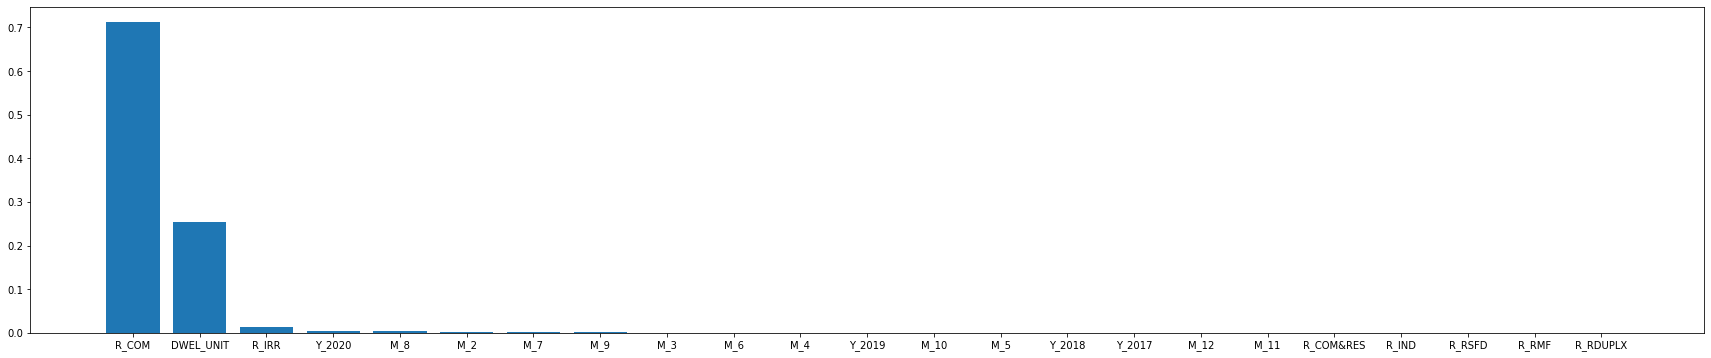

In [333]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_validate

rf_regressor = RandomForestRegressor()

n_est = [int(n) for n in np.logspace(start= 1, stop= 3, num=100)]
grid_params = {'n_estimators': n_est}


rf_grid_cv = GridSearchCV(rf_regressor, param_grid= grid_params, cv= 5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print('Tuned Number of Estimators:', rf_grid_cv.best_params_)

best_rfreg = rf_grid_cv.best_estimator_ 
cv_score_best_rfreg = cross_validate(best_rfreg , X_train, y_train, cv=5)
mean_cv_score_best_rfreg = cv_score_best_rfreg['test_score'].mean()
std_cv_score_best_rfreg = cv_score_best_rfreg['test_score'].std()



feature_impt = pd.Series( rf_grid_cv.best_estimator_.feature_importances_, 
                        X.columns).sort_values(ascending= False)

feature_table = pd.DataFrame(feature_impt.reset_index())
feature_table.columns= ['Features', 'Importance']

print('\nFeature Importance:\n', feature_table)
plt.figure(figsize=(30,6))
plt.bar(x=feature_impt.index, height= feature_impt)
plt.title('Feature Importance')
plt.show()




In [339]:
from sklearn.metrics import mean_absolute_error


cv_score_best_rfreg_train = cross_validate(best_rfreg , X_train, y_train, cv=5)
mean_cv_score_best_rfreg_train = round(cv_score_best_rfreg_train['test_score'].mean(), 2)
std_cv_score_best_rfreg_train = round(cv_score_best_rfreg_train['test_score'].std(),2)
MAE_train = round(mean_absolute_error(y_train, rf_grid_cv.best_estimator_.predict(X_train)),1)

print('Cross Validation Score on Train Set')
print('      mean: ', mean_cv_score_best_rfreg_train)
print('      std: ', std_cv_score_best_rfreg_train)
print('      mean absolute error on test set:', MAE_train)



cv_score_best_rfreg_test = cross_validate(best_rfreg , X_test, y_test, cv=5)
mean_cv_score_best_rfreg_test = round(cv_score_best_rfreg_test['test_score'].mean(), 2)
std_cv_score_best_rfreg_test = round(cv_score_best_rfreg_test['test_score'].std(), 2)
MAE_test = round(mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test)),1)

print('\n\nCross Validation Score on Test Set')
print('      mean: ', mean_cv_score_best_rfreg_test)
print('      std: ', std_cv_score_best_rfreg_test)
print('      mean absolute error on test set:', MAE_test)

Cross Validation Score on Train Set
      mean:  0.16
      std:  0.82
      mean absolute error on test set: 4750.5


Cross Validation Score on Test Set
      mean:  0.55
      std:  0.25
      mean absolute error on test set: 262818.9


# 3) SARMAX Model
Seasonal Autoregressive Moving Average 

## Steps:



### 1) Detrending
Detrending means accounting for a change in mean over time (periodic trend)
#### non-stationary
#### seasonality

#### Signal: seasonal variability. elments of signal are trends, periodicity, autocorrelation.
question is after eliminating all elements of signal, will I left with white noise or not?
#### Noise: random probabilistic processes



### 2) Autocorrelation 
Autocorrelation measures correlation between a time series and itself, at different 'lags'(shift in time).
**Memory** are values in on time period influence values in subsequent time periods. We quantify this memory as autocorrelation. So, autocorrelation accounts for memory in the system. Try to take all signals out and noise, take out all useful part that actually is instructive for making model.

Autocorrelation function can be used for two purposes:

1) to detect non-randomness in data
2) to identify an appropriate time series model if the data are not random 


### 3) Outliers

### 4) Low Pass filters 
Low frequency variations (long period waves) are allowed to 'pass through' the filter, because they are barely affected by somoothing.

A statistical filter, is a series of weights that when cumulatively multiplied by values of time series gives the filtered series.
We retain high amplitude events that don’t occur very often and we want get ride of events that occur pretty frequently (filtered time series).

#### Smoothing

##### 4.1) Moving average
##### 4.2) Exponential

## 3.1) Is the time series of water usage stationary or random walk?

### Check stationary of time series using Augmented Dicky-Fuller test (ADF)

#### Null hypothesis: 
the time series follows a random walk. (There is a unit root)


#### Alternative hypothesis:  
The time series is stationary 


In [341]:
#Create a time series usage
temp_df = data.groupby([data.month_start])['usage'].sum().to_frame()
temp_df.reset_index(inplace=True)
temp_df.head()

,month_start,usage
0,2017-08-01,1948856.0
1,2017-09-01,1645721.8
2,2017-10-01,1807765.8
3,2017-11-01,1526451.0
4,2017-12-01,1516514.6


In [340]:
def test_stationary(timeseries, order):
    
    #Calculate Moving avg and moving std for each season
    rol_mean = timeseries.rolling(window= 3).mean()
    rol_std = timeseries.rolling(window= 3).std()
 
    
    #plot rolling statistics
    plt.figure(figsize=(12,6))
    ax = plt.plot(timeseries, label= 'Original', color= 'green')
    label_mean = 'Rolling Mean = {}'.format(round(timeseries.mean(), 1))
    plt.plot(rol_mean, label= label_mean, color= 'red')
    label_std = 'Rolling_std = {}'.format(round(timeseries.std(), 1))
    plt.plot(rol_std, label= label_std)
    plt.ylabel('Water Usage(Million Gallons)', fontsize= 13)
    
    title = 'Rolling Mean and Stadard Deviation, {} Order of Difference'.format(order)
    plt.title(title, fontsize=16, color= 'purple')
    plt.grid(which='both')
    plt.legend()
    plt.show()    

### ACF and PACF charts for the seasonal difference of usages  

In [342]:
#Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller


#Perform Dicky-Fuller test    
def adf_test(timeseries):  
    print('\nResults of Dickey-Fuller Test:')
        
    # Set autolag as AIC, so the number of lags is chosen to minimize the corresponding information criterion.
    df_test = adfuller(timeseries, autolag= 'AIC') 


    df_output = pd.Series(df_test[0:4] , index= ['test statistic', 'p-value', '# Lags Used','# Observation Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value {}'.format(key)] = value
    print(df_output)   

In [343]:
print('0 Order of Difference')
adf_test(temp_df['usage'])


0 Order of Difference

Results of Dickey-Fuller Test:
test statistic        -4.816783
p-value                0.000051
# Lags Used            5.000000
# Observation Used    30.000000
Critical Value 1%     -3.669920
Critical Value 5%     -2.964071
Critical Value 10%    -2.621171
dtype: float64


###  test statistic < Critical value at all levels , so the null hypothesis can be rejected. Time series of water usage is stationary.

### Check if the water usages have strong stationarity or weak statinarity? 

**Strong Stationary:** entire distribution of water usage is time invariant. 

**Weak Stationary:** mean, variance and autocorrelation are time invariant.

### 3.1.1.  Visualize the data

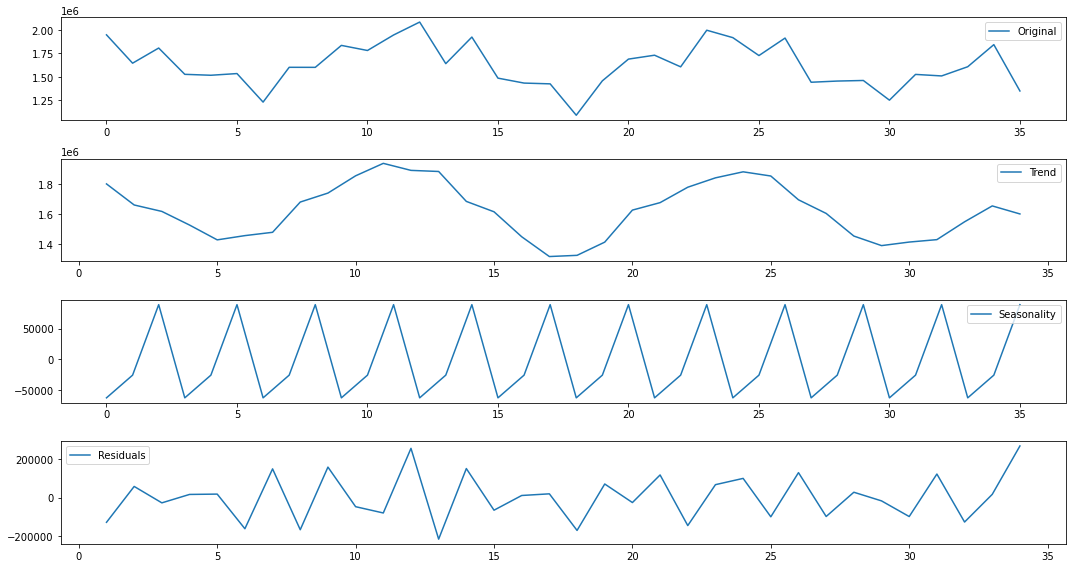

In [344]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Decomposite signal and noise
decomposition = seasonal_decompose(temp_df['usage'] , period= 3)

trend = decomposition.trend
seasonal = decomposition.seasonal
#Residual values take out the trend and seasonality of the data and they are independent of time.
residual = decomposition.resid


#Plot the decomposition elements
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(temp_df['usage'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

#decomposition.plot()
plt.tight_layout()
plt.show()


### 3.1.2. Stationarize data

Mean and std of usage series are functions of time.

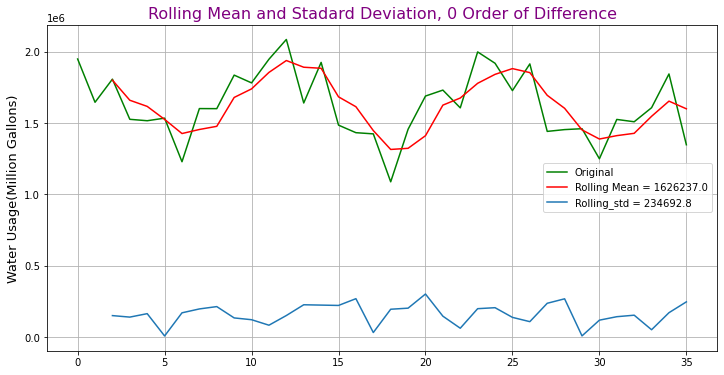

0 Order of Difference

Results of Dickey-Fuller Test:
test statistic        -4.816783
p-value                0.000051
# Lags Used            5.000000
# Observation Used    30.000000
Critical Value 1%     -3.669920
Critical Value 5%     -2.964071
Critical Value 10%    -2.621171
dtype: float64


In [345]:
#Test stationarity for the 0 order of difference of usage 

test_stationary(temp_df['usage'],0)

print('0 Order of Difference')
adf_test(temp_df['usage'])

###  test statistic < Critical value at all levels , so the null hypothesis can be rejected. Time series of water usage is stationary.

In [346]:
#Compute the first difference of water usage 
temp_df['seasonal_difference1'] = temp_df['usage'].diff(1)

#Compute the second difference of water usage 
temp_df['seasonal_difference2'] = temp_df['usage'].diff(2)

#Compute the third difference of water usage 
temp_df['seasonal_difference3'] = temp_df['usage'].diff(3)

#Compute the forth difference of water usage 
temp_df['seasonal_difference4'] = temp_df['usage'].diff(4)


#Compute the sixth difference of water usage 
temp_df['seasonal_difference6'] = temp_df['usage'].diff(6)

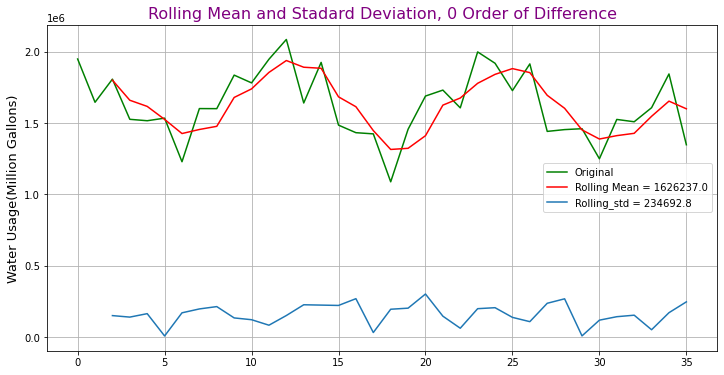

Varying mean over the time shows trend



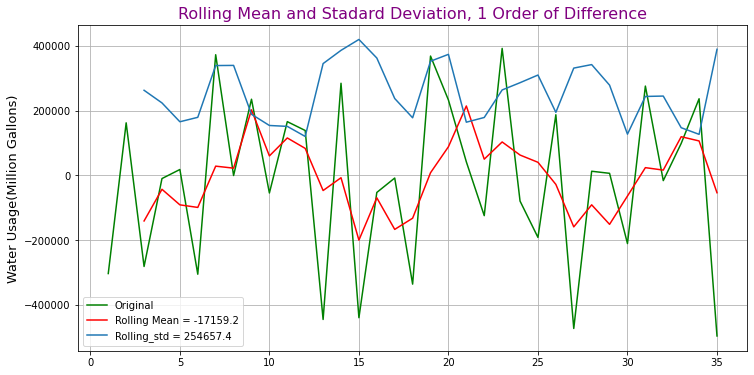

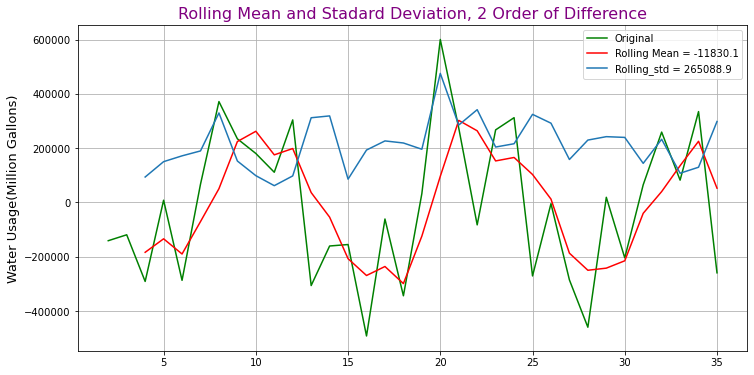

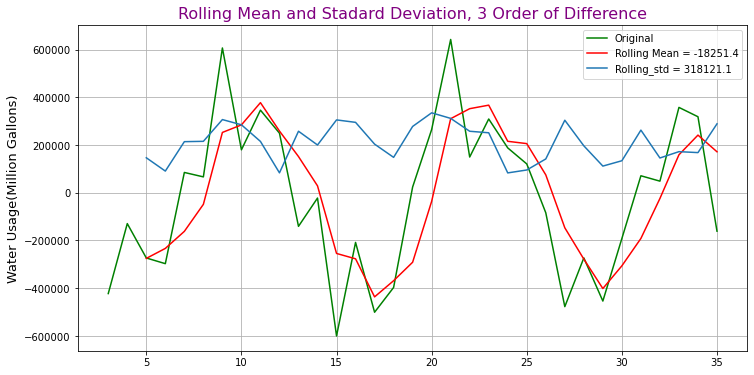

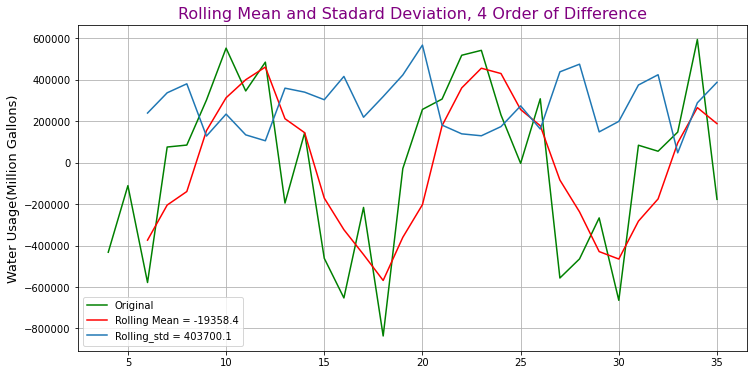

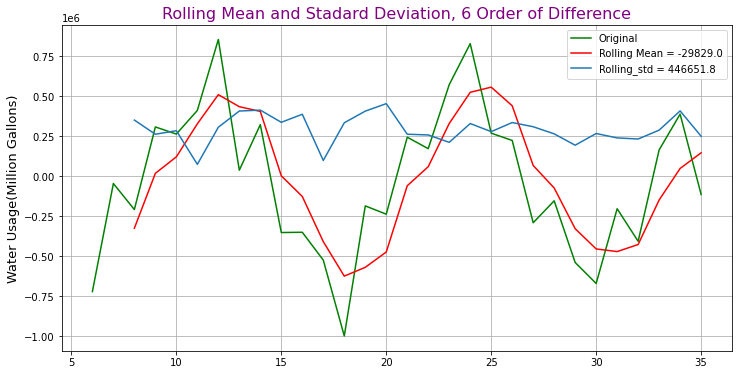

In [347]:
#Test stationarity for the 0 to forth difference of usage 
test_stationary(temp_df['usage'],0)
print('Varying mean over the time shows trend\n')

test_stationary(temp_df['seasonal_difference1'].dropna(inplace= False), 1)

test_stationary(temp_df['seasonal_difference2'].dropna(inplace= False), 2)

test_stationary(temp_df['seasonal_difference3'].dropna(inplace= False), 3)

test_stationary(temp_df['seasonal_difference4'].dropna(inplace= False), 4)

test_stationary(temp_df['seasonal_difference6'].dropna(inplace= False), 6)

**Time series of first order of difference has well fluctuated around the mean and has the lowest standard deviation. Increasing the order of difference didn't reduce the std.**

### Quartely change in water usage is not white noise.
    1) Mean is not constant with time, 

    2) Variance is not constant with time, and 

    3) Autocorrelation at all lags are not zero.

**So the past will help me forecast the future.**


In [348]:
print('1 Order of Difference')
adf_test(temp_df['seasonal_difference1'].dropna(inplace= False))

print('\n--------------------------\n2 Order of Difference')
adf_test(temp_df['seasonal_difference2'].dropna(inplace= False))

print('\n--------------------------\n3 Order of Difference')
adf_test(temp_df['seasonal_difference3'].dropna(inplace= False))

print('\n--------------------------\n4 Order of Difference')
adf_test(temp_df['seasonal_difference4'].dropna(inplace= False))

print('\n--------------------------\n6 Order of Difference')
adf_test(temp_df['seasonal_difference6'].dropna(inplace= False))


1 Order of Difference

Results of Dickey-Fuller Test:
test statistic        -4.935886
p-value                0.000030
# Lags Used            7.000000
# Observation Used    27.000000
Critical Value 1%     -3.699608
Critical Value 5%     -2.976430
Critical Value 10%    -2.627601
dtype: float64

--------------------------
2 Order of Difference

Results of Dickey-Fuller Test:
test statistic        -3.176677
p-value                0.021375
# Lags Used            9.000000
# Observation Used    24.000000
Critical Value 1%     -3.737709
Critical Value 5%     -2.992216
Critical Value 10%    -2.635747
dtype: float64

--------------------------
3 Order of Difference

Results of Dickey-Fuller Test:
test statistic        -2.998330
p-value                0.035051
# Lags Used            9.000000
# Observation Used    23.000000
Critical Value 1%     -3.752928
Critical Value 5%     -2.998500
Critical Value 10%    -2.638967
dtype: float64

--------------------------
4 Order of Difference

Results of Dic

### For 1, 4 and 6 order of difference (not for 2 or 3), test statistic < Critical value at all levels, so time series of usage is stationary and doesn't follow a random walk.

3. Plot ACF and PACF and find the optimal parameters

C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


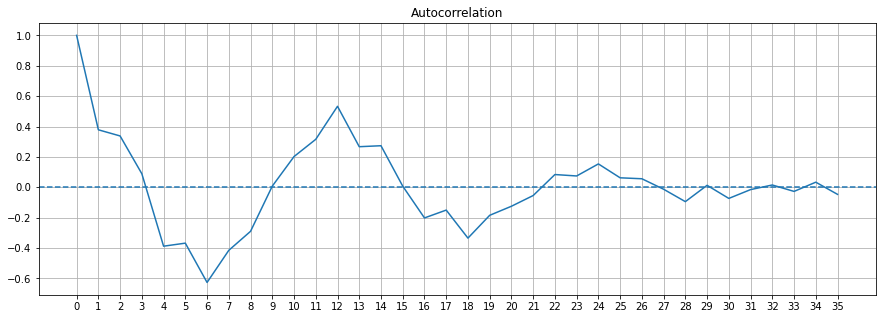

In [350]:
# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Compute the acf array of usage
acf_array = acf(temp_df.usage)

plt.figure(figsize=(15,5))
plt.plot(range(len(acf_array)), acf_array)
plt.xticks(range(len(acf_array)))
plt.axhline(y=0, linestyle= 'dashed')
plt.grid(which='both')
plt.title('Autocorrelation')
plt.show()

C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


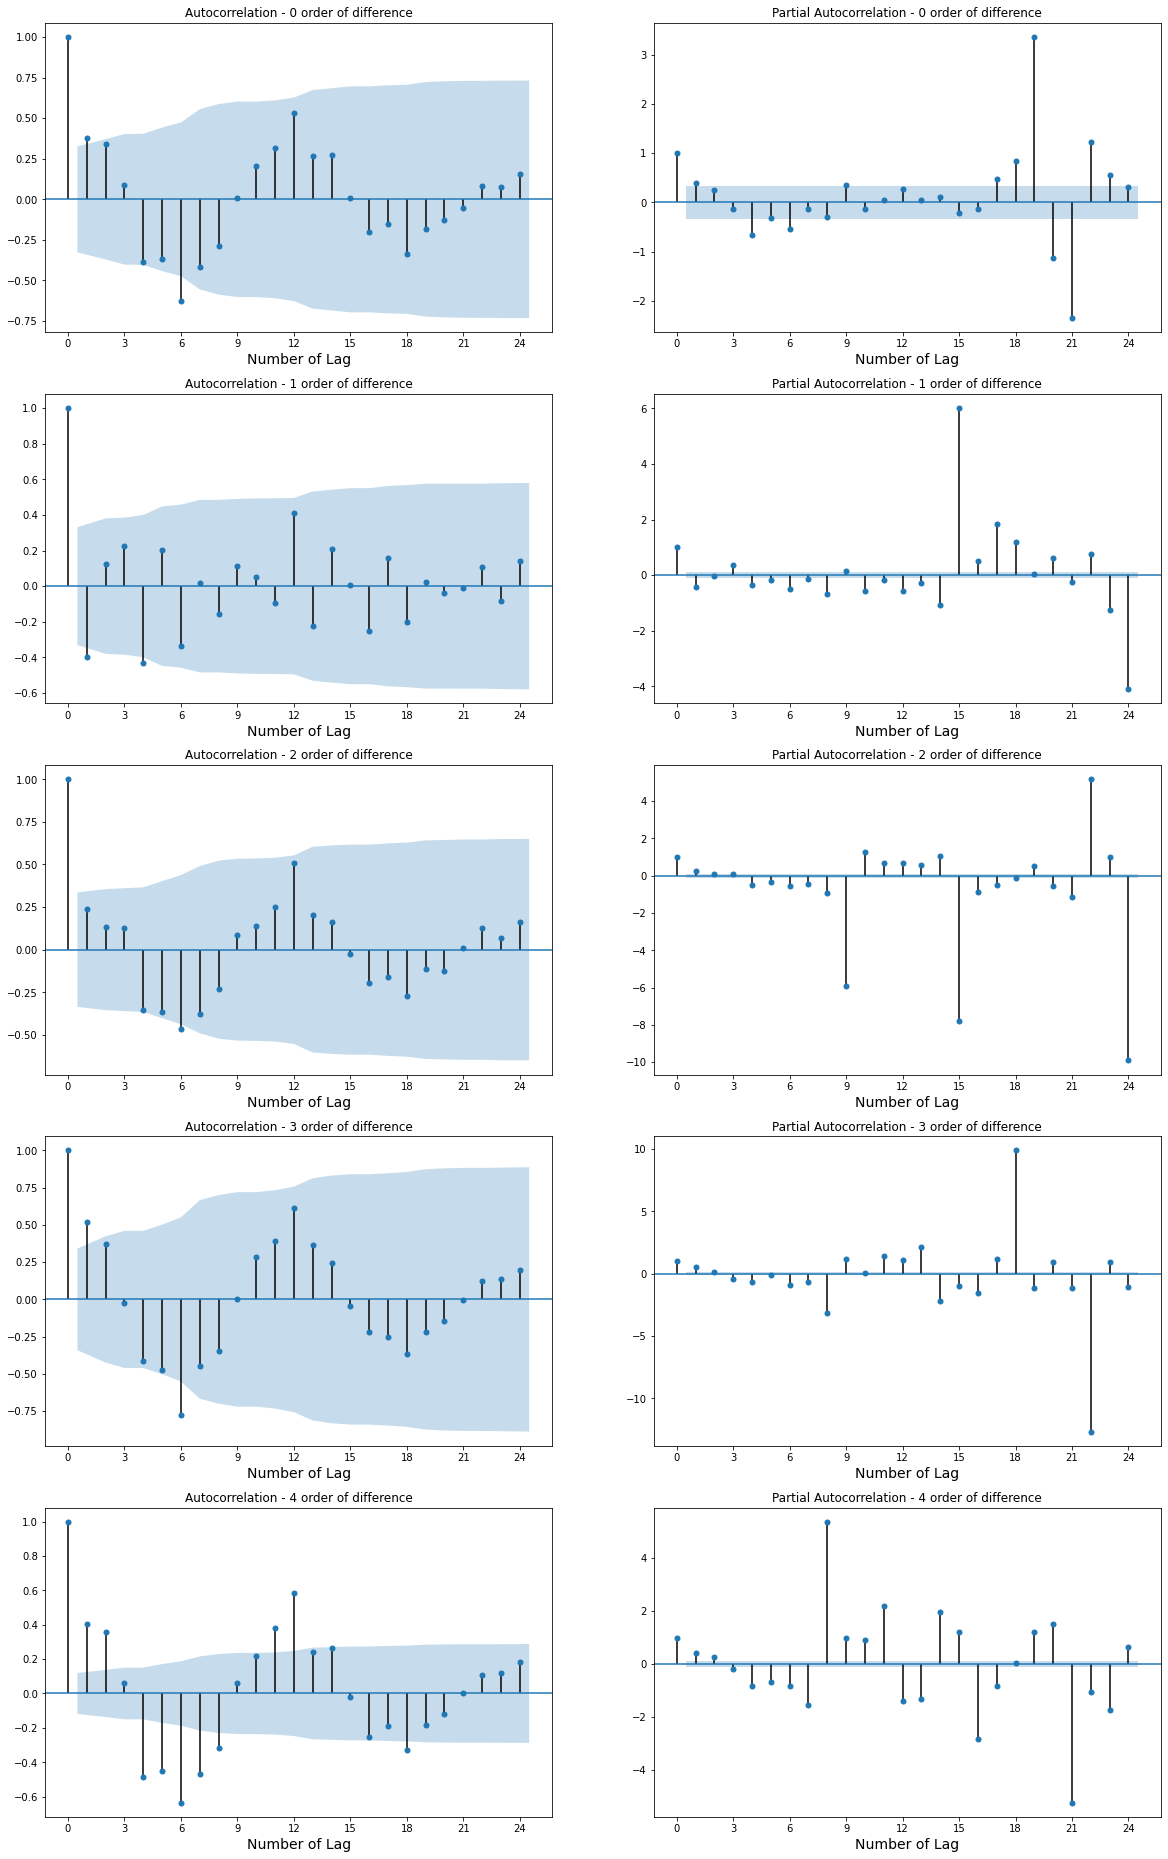

In [351]:
#Plot autocorrelation function of difference in quarterly water usage amount, set the confidence interval of 95%
fig = plt.figure(figsize=(20,33))

ax1 = fig.add_subplot(5,2,1)
fig = plot_acf(temp_df['usage'].dropna(), lags= 24, alpha=.05, ax= ax1)
ax1.set_title('Autocorrelation - 0 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])

ax2 = fig.add_subplot(5,2,2)
fig = plot_pacf(temp_df['usage'].dropna(), lags= 24, alpha=.05, ax= ax2)
ax2.set_title('Partial Autocorrelation - 0 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])

ax3 = fig.add_subplot(5,2,3)
fig = plot_acf(temp_df['seasonal_difference1'].dropna(), lags= 24, alpha=.05, ax= ax3)
ax3.set_title('Autocorrelation - 1 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])


ax4 = fig.add_subplot(5,2,4)
fig = plot_pacf(temp_df['seasonal_difference1'].dropna(), lags = 24, alpha = 0.5, ax= ax4)
ax4.set_title('Partial Autocorrelation - 1 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])


ax5 = fig.add_subplot(5,2,5)
fig = plot_acf(temp_df['seasonal_difference2'].dropna(), lags= 24, alpha=.05, ax= ax5)
ax5.set_title('Autocorrelation - 2 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])


ax6 = fig.add_subplot(5,2,6)
fig = plot_pacf(temp_df['seasonal_difference2'].dropna(), lags = 24, alpha = 0.5, ax= ax6)
ax6.set_title('Partial Autocorrelation - 2 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])


ax7 = fig.add_subplot(5,2,7)
fig = plot_acf(temp_df['seasonal_difference3'].dropna(), lags= 24, alpha=.05, ax= ax7)
ax7.set_title('Autocorrelation - 3 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])


ax8 = fig.add_subplot(5,2,8)
fig = plot_pacf(temp_df['seasonal_difference3'].dropna(), lags = 24, alpha = 0.5, ax= ax8)
ax8.set_title('Partial Autocorrelation - 3 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])


ax9 = fig.add_subplot(5,2,9)
fig = plot_acf(temp_df['seasonal_difference4'].dropna(), lags = 24, alpha = 0.5, ax= ax9)
ax9.set_title('Autocorrelation - 4 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])


ax10 = fig.add_subplot(5,2,10)
fig = plot_pacf(temp_df['seasonal_difference4'].dropna(), lags = 24, alpha = 0.5, ax= ax10)
ax10.set_title('Partial Autocorrelation - 4 order of difference')
plt.xlabel('Number of Lag', fontsize= 14)
plt.xticks([0,3,6,9,12,15,18,21,24])

plt.show()

### a) The autocorrelation function of zero order of usage:
####  a1) has pattern because it has seasonal pattern.
####  a2) is positive in lag-one, lag-two, lag-three. Most of them are significantly different from zero. This implies that series can be forecasted from the past.

### b) Autocorrelation function of one order of difference is patternless, because seasonality adjustment eliminated the pattern. Lag-1 autocorrelation function is negative.

### c) Autocorrelation plot for the extra orders of differencing show pattern but this overdifferencing cause a common "rookie error" in ARIMA modeling.

#### The Partial Autocorrelation Function measures the incremental benefit of adding another lag.

# What is SARMA model?

## Forecasting based on presence of trend and seasonality


### Hyperparameters of SARMA model-  SARIMA(p,d,q)(P,D,Q)m


#### Trend elements (p, d, q)  ~  (trend AR order, trend difference order, trend MA order)
**q is order of the model for Number of AMA **: 

The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case **q=1**.
For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.



**p is order of the model for the number of AR parameters(autoregressive)**: 

The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case **p=1**.

*Autoregressive model:     yt = c + sum( ϕi * yt-i) +  ϵt* 

For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).




**d is Number of nonseasonal differences**

In this case the first order of difference is nonseasonal. So either we can pass that variable and put d=0 or pass the original variable and put **d=1**. Both will generate same results.




#### Seasonal Elements (P,D,Q)m  

P: Seasonal autoregressive order.

D: Seasonal difference order.

Q: Seasonal moving average order.

m: The number of time steps for a single seasonal period.

For example, an m of 12 for monthly data suggests a yearly seasonal cycle. in this case, **seasonality is quarterly so m=4**.

the m parameter influences the P, D, and Q parameters



#### The implementation is called SARIMAX instead of SARIMA because the “X” addition to the method name means that the implementation also supports exogenous variables.

Exogenous variables are optional can be specified via the “exog” argument.

### Equation of  ARIMAX:        Δyt = c + βX + sum( ϕi * Δyt-i) + sum(θi * ϵt-i) + ϵt


equation for the ARMAX (the order of integration is 0): yt = c + βX + sum( ϕi * yt-i) + sum(θi * ϵt-i) + ϵt


 ϵt-i : errors
 
 ϵt : white noise with variance of sigma^2. error term contributes to the likelihood of the model 
 
 c : constant factor

 ϕi : how much past values contribute in current forecast
 
 θi : how much error of past values contribute in current forecast
 
 X :  an exogenous variable (such as rainfall level) that we can add, not determined by model. It is a factor that impact the time series values. Its value is determined be factors of variable outside the model.

In [352]:
#Create a time series usage
temp_df = data.groupby([data.month_start])['usage'].sum().to_frame()
temp_df.reset_index(inplace=True)
temp_df.head()

,month_start,usage
0,2017-08-01,1948856.0
1,2017-09-01,1645721.8
2,2017-10-01,1807765.8
3,2017-11-01,1526451.0
4,2017-12-01,1516514.6


In [353]:
#set train and test size (70/30)
n = temp_df.shape[0]
n1 =  int(0.70 * n)
n2 = int(n - n1)

In [354]:
ar = 1          # this is the maximum degree specification
ma = (1,0,0,0)  # this is the lag polynomial specification

sarimax = sm.tsa.statespace.SARIMAX(temp_df.loc[:n1, 'usage'], trend='c', order=(ar,1,ma))
res_sarimax = sarimax.fit(disp=False)
res_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  usage   No. Observations:                   26
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -343.429
Date:                Sun, 28 Feb 2021   AIC                            694.857
Time:                        16:47:06   BIC                            699.733
Sample:                             0   HQIC                           696.210
                                 - 26                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.189e+04   5.73e+04      0.207      0.836      -1e+05    1.24e+05
ar.L1         -0.3865      0.710     -0.544      0.586      -1.778       1.005
ma.L1          0.1752      0.789      0.222      0.824      -1.371       1.721
sigma2      5.353e+10      0.043   1.25e+12      0.000    5.35e+10    5.35e+10
===================================================================================
Ljung-Box (Q):                       25.47   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.38   Prob(JB):                         0.55
Heteroskedasticity (H):               1.88   Skew:                            -0.26
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.75e+27. Standard errors may be unstable.
"""

#### The maximum likelihood estimates imply that for the process above, I have:

##### Δyt =  1.189e+04 + (-0.3865) Δyt−1 + (0.1752) ϵt−1 + ϵt

##### where  ϵt ∼ N (0 ,5.353e+10)

In [355]:
res_sarimax.params

intercept    1.188994e+04
ar.L1       -3.864606e-01
ma.L1        1.751861e-01
sigma2       5.353072e+10
dtype: float64

### The information criteria adjusts the goodness-of-fit of a model by imposing a penalty based on the number of parameters used. 
### The way to use the information criteria is to fit several models, each with a different number of parameters, and choose the one with the lowest Bayesian information criterion.

In [356]:
print('Two common adjusted goodness-of-fit measures:')

# to get Bayesian Information Criteria
print('AIC:' , res_sarimax.bic)

# to get Akaike Information Criteria
print('BIC:', res_sarimax.aic)

Two common adjusted goodness-of-fit measures:
AIC: 699.7327544486507
BIC: 694.8572511491778


Make predictions

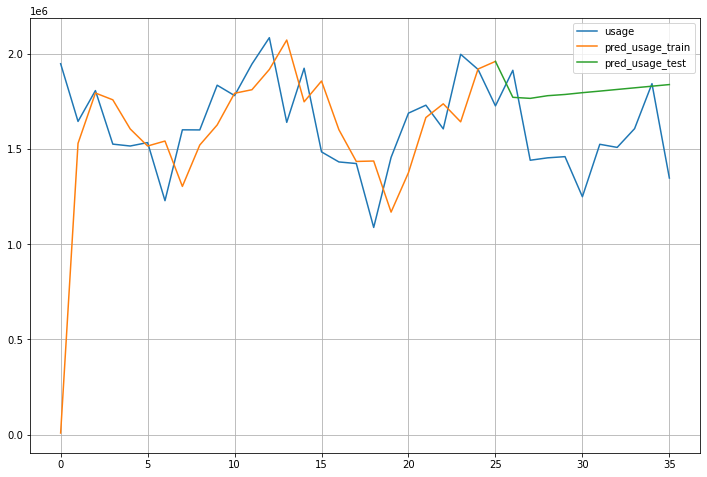

In [357]:
temp_df['pred_usage_train'] = res_sarimax.predict(start=0, end= n1)
temp_df['pred_usage_test'] = res_sarimax.predict(start=n1, end= n)
temp_df[['usage', 'pred_usage_train','pred_usage_test']].plot(figsize=(12,8))
plt.grid(which= 'both')
plt.show()

## Fast Bayesian Estimation of SARIMAX Model

#### The model order parameters are auto-regressive, difference, and moving average orders respectively.

##### Steps to find the optimum parameters:

      1) Load libraries
        
      PyMC3: is a Bayesian estimation library ('Probabilistic Programming in Python: Bayesian Modeling and Probabilistic 
      ML with Theano')
        
      Theano: a library that aims to evaluate tensors(A tensor is a generalization of vectors and matrices as a  
      multidimensional array) very efficiently and provide symbolic differentiation.
        
      PyMC3 is built on top of a Theano.
      
        
      2) Instantiate a SARIMA model
      
      The Jacobian of a set of functions is a matrix of partial derivatives of the functions. If you have just one function 
      instead of a set of function, the Jacobian is the gradient of the function.
      
      Statsmodels SARIMAX objects have a method to return the Jacobian evaluated at the parameter values. It provides 
      gradients so that we can use NUTS.
      
      4) Use the instantiated model to estimate parameters via fitting the model with Maximum Likelihood Estimation
      
      5) Use the instantiated model for the Bayesian estimation
        
 Source: https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_pymc3.html       
        
        

In [358]:
%matplotlib inline
import theano
import theano.tensor as tt

import pymc3 as pm   # Bayesian estimation library


from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

In [359]:
#Set train and test size
m = int(0.80 * len(temp_df))

In [360]:
#Instantiate an SARIMAX model
mod = sm.tsa.statespace.SARIMAX(temp_df.loc[:m, 'usage'] ,order=(1,1,1))
res_mle = mod.fit(disp=False)
res_mle.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  usage   No. Observations:                   29
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -385.264
Date:                Sun, 28 Feb 2021   AIC                            776.528
Time:                        16:49:39   BIC                            780.524
Sample:                             0   HQIC                           777.749
                                 - 29                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3821      0.728     -0.525      0.600      -1.809       1.044
ma.L1          0.1620      0.802      0.202      0.840      -1.411       1.735
sigma2      5.551e+10   9.21e-12   6.02e+21      0.000    5.55e+10    5.55e+10
===================================================================================
Ljung-Box (Q):                       35.78   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.12   Prob(JB):                         0.50
Heteroskedasticity (H):               1.64   Skew:                            -0.27
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.87e+38. Standard errors may be unstable.
"""

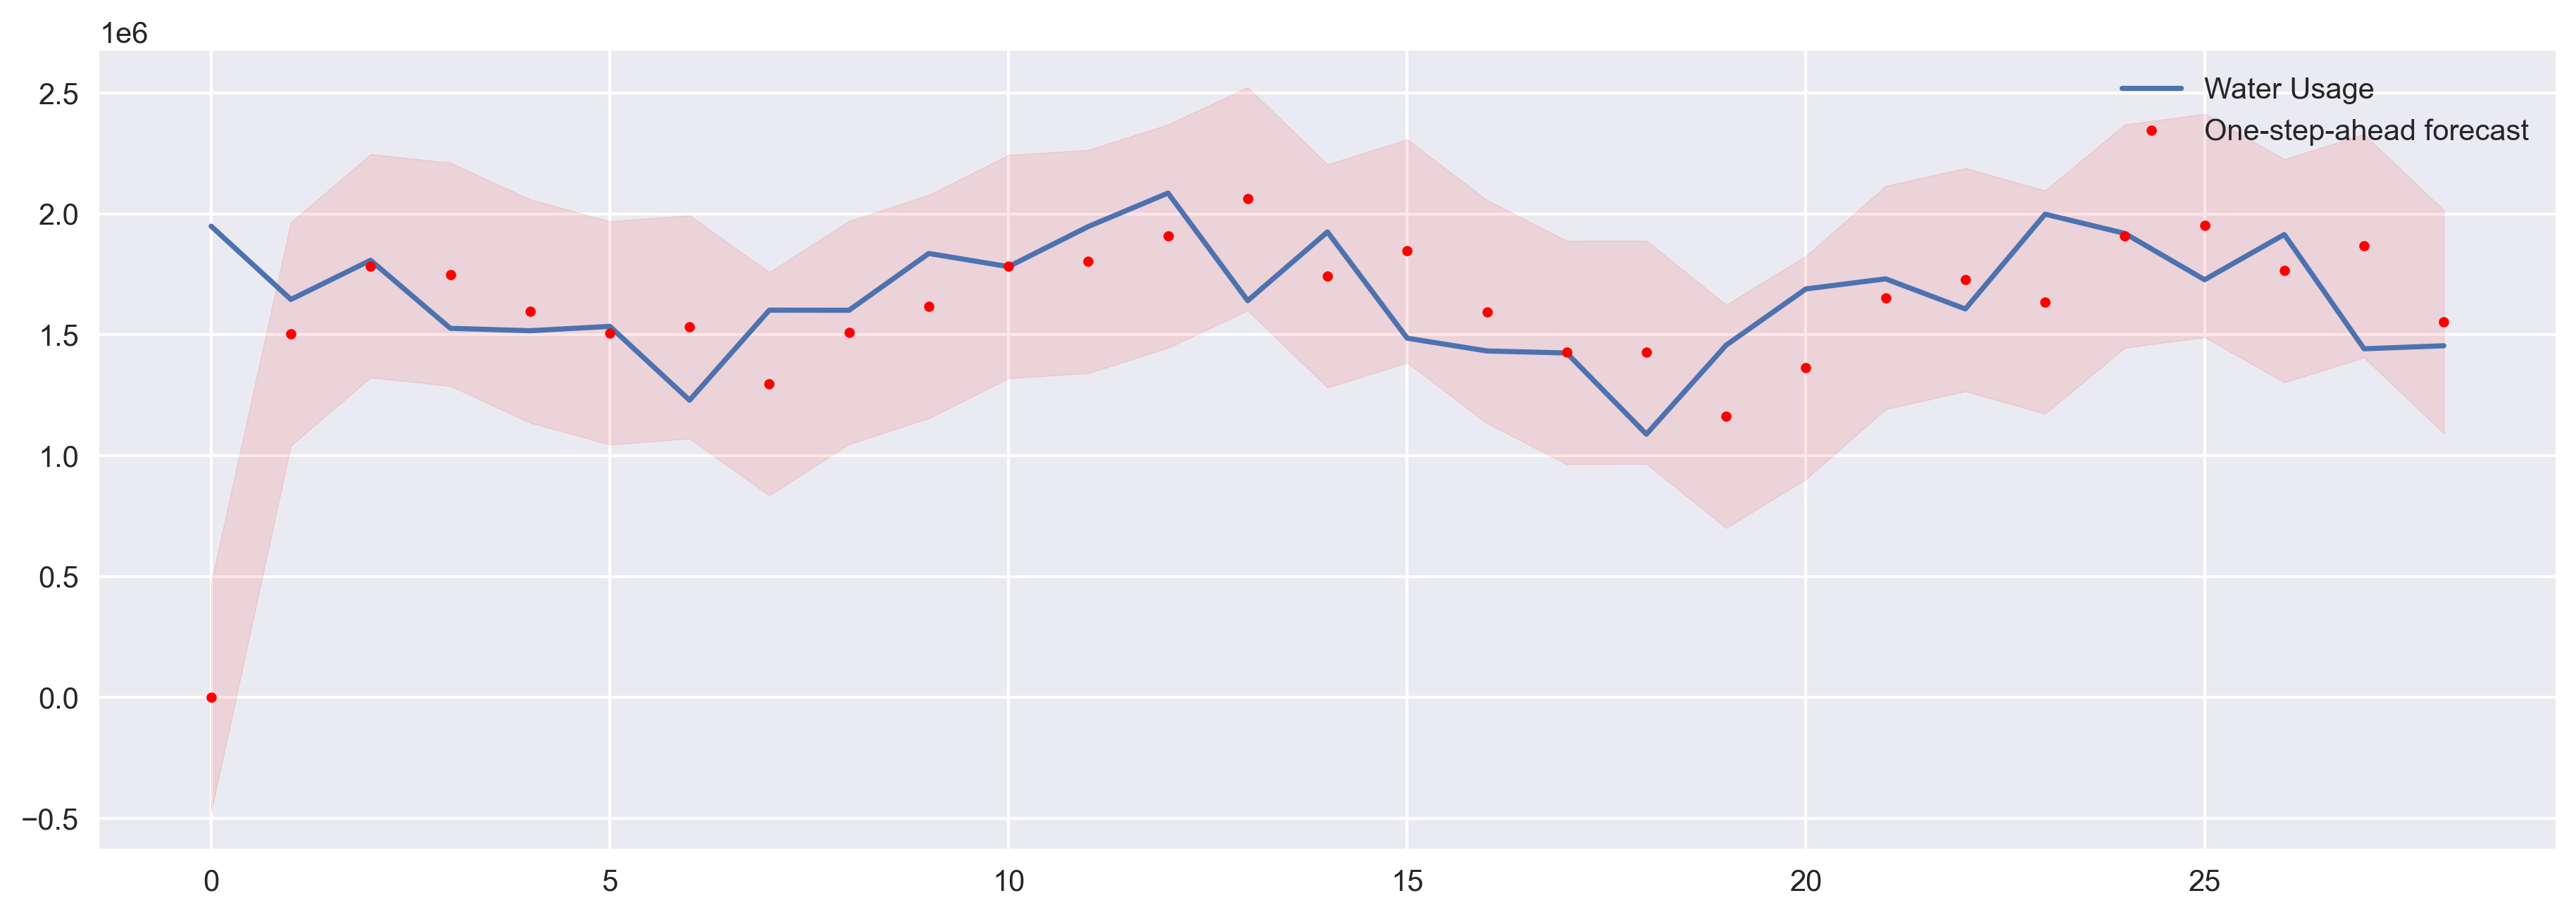

In [361]:
#Get the prediction
predict_mle = res_mle.get_prediction()

#Extract lower and upper bonds of confidence interval
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower usage']
upper = predict_mle_ci['upper usage']

# Graph
fig, ax = plt.subplots(figsize=(15,5), dpi=300)

# Plot data points
temp_df.loc[:m, 'usage'].plot(ax=ax, style='-', label='Water Usage')

# Plot the series of one-step ahead predictions
predict_mle.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='best')
plt.show()

#### Defining helper functions to translate models into a PyMC3 friendly form.
Create the Theano wrappers in the form of 'Ops', operation objects, that perform particular tasks. They are initialized with a statsmodels model instance.

In [362]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

## Bayesian estimation with NUTs

In [363]:
# Set sampling params
ndraws = 100   # number of draws from the distribution
nburn = 10    # number of "burn-in points" (which will be discarded)

### Construct an instance of the Theano wrapper:
which will allow PyMC3 to compute the **likelihood and Jacobian** in a way that it can make use of. 

#### Build a Bayesian model by determining specification of a full probability model for water usage problem. 
    1) Assign parametric statistical distributions to unknown quantities in the model, 

    2) Appropriate functional forms for likelihoods to represent the information from the data. 

#### Equation of ARIMAX:      Δyt = c + βX + sum( ϕi * Δyt-i) + sum(θi * ϵt-i) + ϵt

equation for the ARMAX (the order of integration is 0): yt = c + βX + sum( ϕi * yt-i) + sum(θi * ϵt-i) + ϵt


 ϵt-i : errors
 
 ϵt : white noise with variance of sigma^2.    ϵt∼N(0, σ2)
 
 c : constant factor

 ϕi : how much past values contribute in current forecast
 
 θi : how much error of past values contribute in current forecast
 
 X :  an exogenous variable (such as rainfall level) that we can add, not determined by model. It is a factor that impact the time series values. Its value is determined be factors of variable outside the model.

In [364]:
#Use instantiated model for MLE analysis
loglike = Loglike(mod)   #Return the concentrated likelihood function evaluated at params


#Call Created PyMC3 class based model
with pm.Model():
    
    #--------Priors--------
    #Using an instance of the uniform class for AR(p) regulariztion
    arL1 = pm.Uniform('ar.L1', -0.99, 0.99)
    
    #using an instance of the unifrom class for MA(q) regularization
    maL1 = pm.Uniform('ma.L1', -0.99, 0.99)
    
    #using an instance of the inverse Gamma class for regularization of σ2 as the variance of error term  
    #error term contributes to the likelihood of the model
    #The posterior distribution of σ2 is inverse gamma parametrized by α and  β
    sigma2 = pm.InverseGamma('sigma2', 250,400)
    
    

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})

    # Draw samples from the domain, represented as a vector
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=4)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2, ma.L1, ar.L1]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]
Sampling chain 3, 0 divergences: 100%|███████| 110/110 [00:14<00:00,  7.65it/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.00018181310154413192, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21226765595063693, but 

C:\Users\bahra\Anaconda\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\bahra\Anaconda\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\bahra\Anaconda\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


<Figure size 576x396 with 0 Axes>

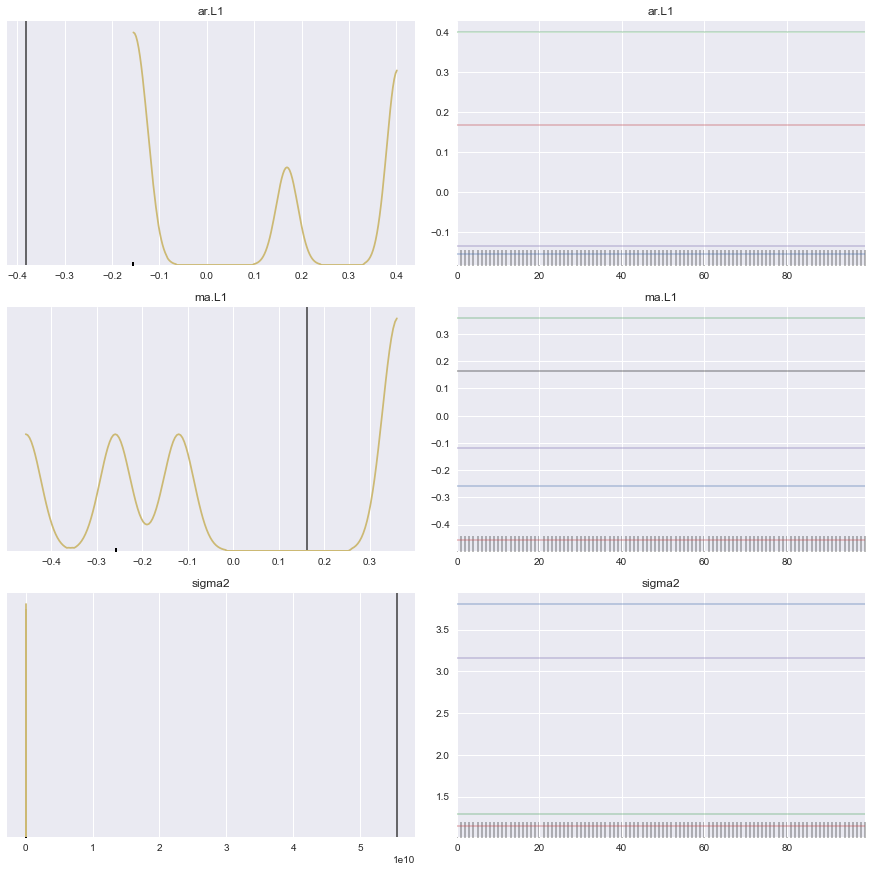

In [365]:
plt.tight_layout()
_ = pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
                 combined=True,
                 figsize=(12, 12))
plt.show()

In [366]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ar.L1,0.070,0.230,-0.155,0.401,0.111,0.084,4.0,4.0,4.0,4.0,11.60
ma.L1,-0.118,0.301,-0.456,0.359,0.144,0.110,4.0,4.0,5.0,12.0,9.48
sigma2,2.353,1.157,1.151,3.809,0.555,0.422,4.0,4.0,4.0,12.0,13.17


#### R^  is the Gelman-Rubin statistic. 
It tests for **lack of convergence** by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. 
**If R^<1.2 for all model parameters, we can have some confidence that convergence has been reached.**

#### The highest posterior density interval (the gap between the two values of HPD in the table) is small for each of the variables.

## Application of Bayesian estimates of parameters

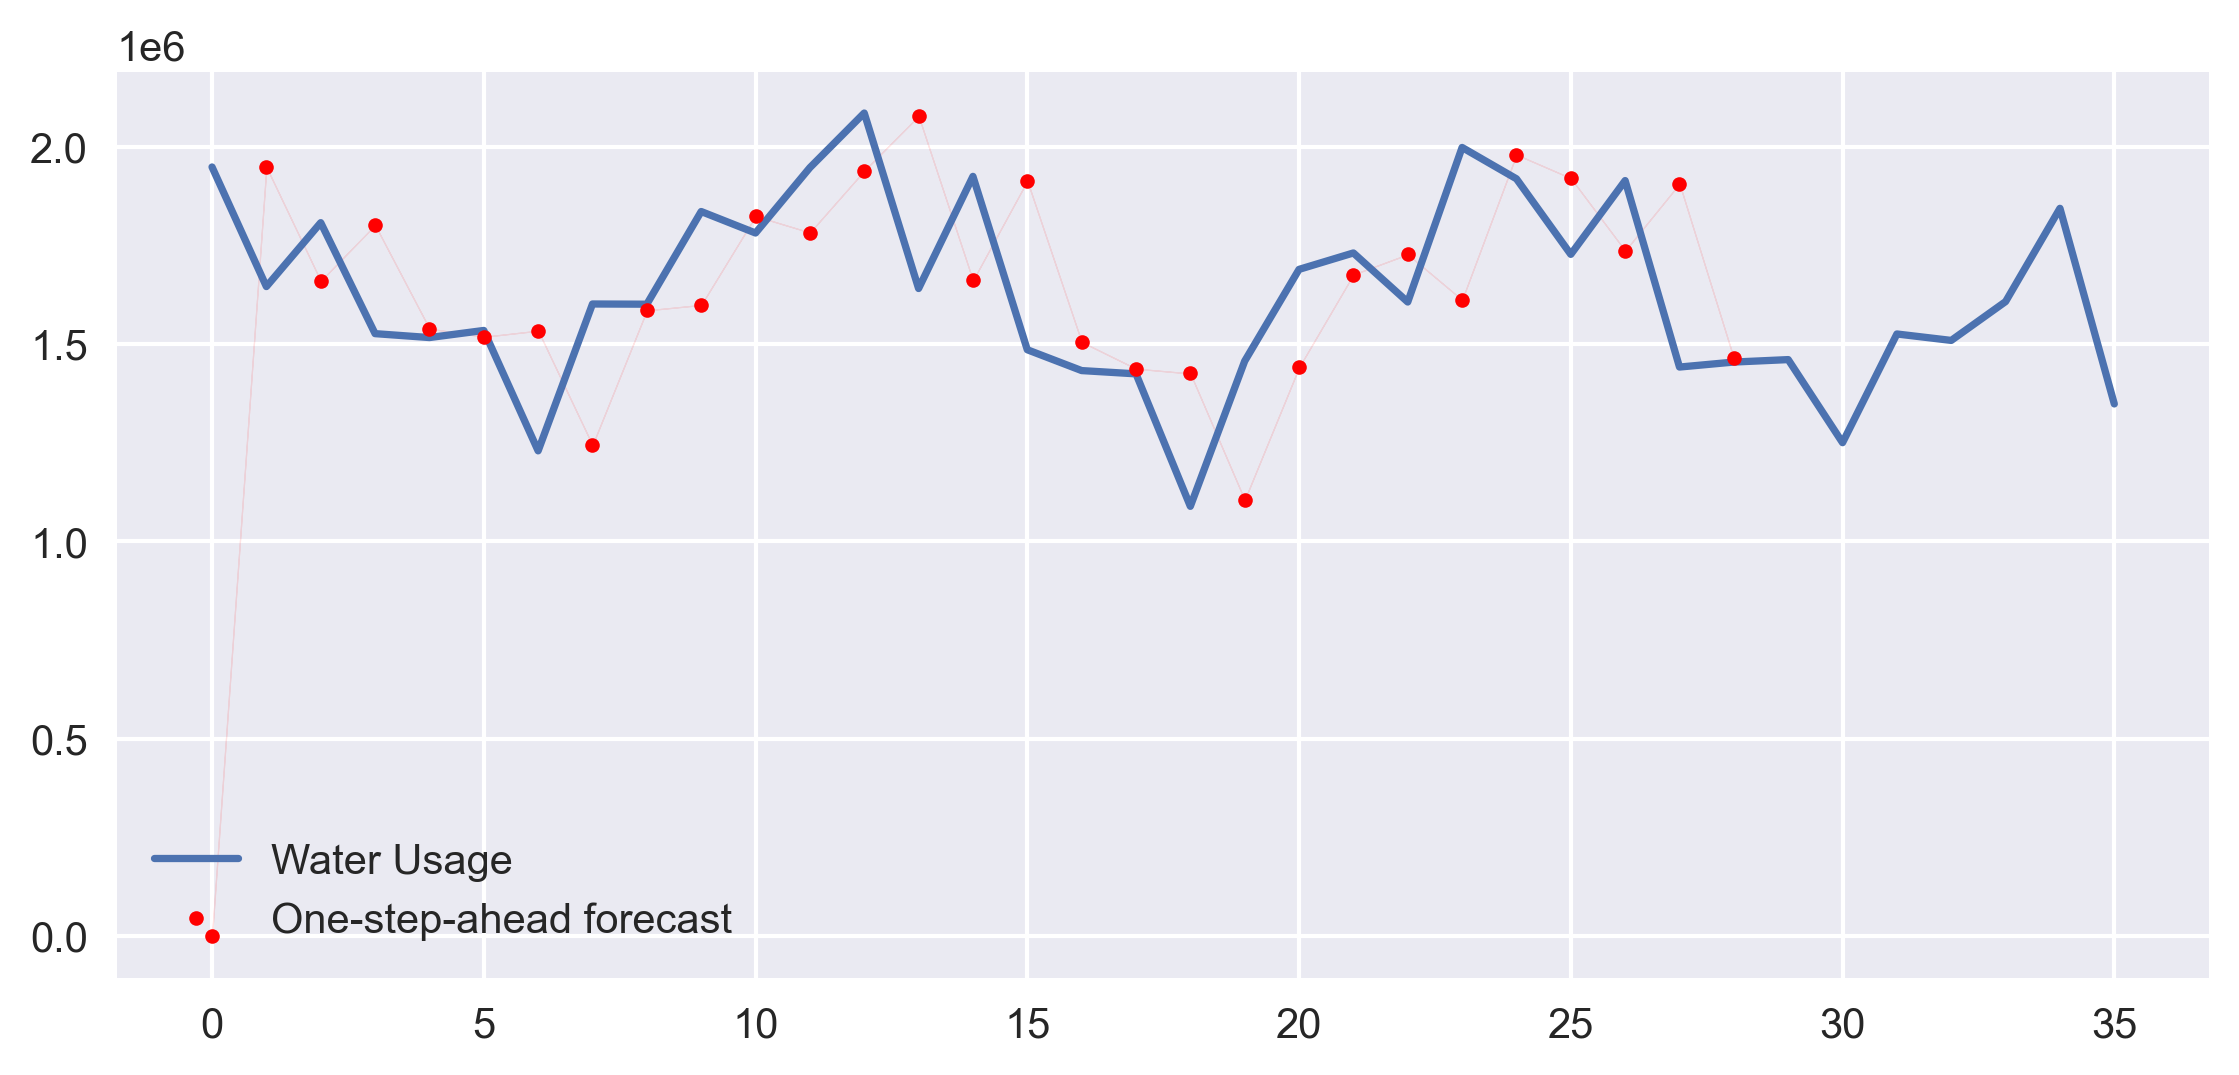

In [367]:
# Retrieve the posterior means
params = pm.summary(trace)['mean'].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()

predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower usage']
upper = predict_bayes_ci['upper usage']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
temp_df.usage.plot(ax=ax, style='-', label='Water Usage')

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_bayes_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()